# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline34IDC.optimization.common as opt_common
import aps.ai.autoalignment.beamline34IDC.optimization.configs as configs
import aps.ai.autoalignment.beamline34IDC.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline34IDC.simulation.facade.focusing_optics_interface import get_default_input_features
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline34IDC.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_plot_utils as apu
from datetime import datetime

import matplotlib as mpl
import cmasher as cm

from epics import ca
ca.finalize_libca()

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':True})

In [5]:
DEFAULT_RANDOM_SEED = 10

In [6]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 6e3,
            "sum_intensity_hard_constraint": 6e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [7]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/34-ID"
    os.chdir(work_dir)

In [8]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [9]:
2560 * 0.65 * 1e-3

1.6640000000000001

In [10]:
detector_x = 0.05
detector_y = 0.05
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.02, 0.02]
yrange_plot = [-0.02, 0.02]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [11]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / 'nf_fwhm_pl_pi'
save_dir.mkdir(exist_ok=True)

In [12]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.025, 0.025], yrange=[-0.025, 0.025], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=10, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FA770F08D60)


In [13]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.02, 0.02], yrange=[-0.02, 0.02], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fa7c0944dc0>)

In [14]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_trans': [-20, 20], 'vb_trans': [-20, 20], 'hb_pitch': [-0.02, 0.02], 'vb_pitch': [-0.02, 0.02], 'hb_1': [-30, 30], 'hb_2': [-30, 30], 'vb_1': [-30, 30], 'vb_2': [-30, 30]}
Optimization parameters
{'sum_intensity_soft_constraint': 6000.0, 'sum_intensity_hard_constraint': 6000.0, 'loss_parameters': ['fwhm', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [15]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features()
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=1,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    #layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


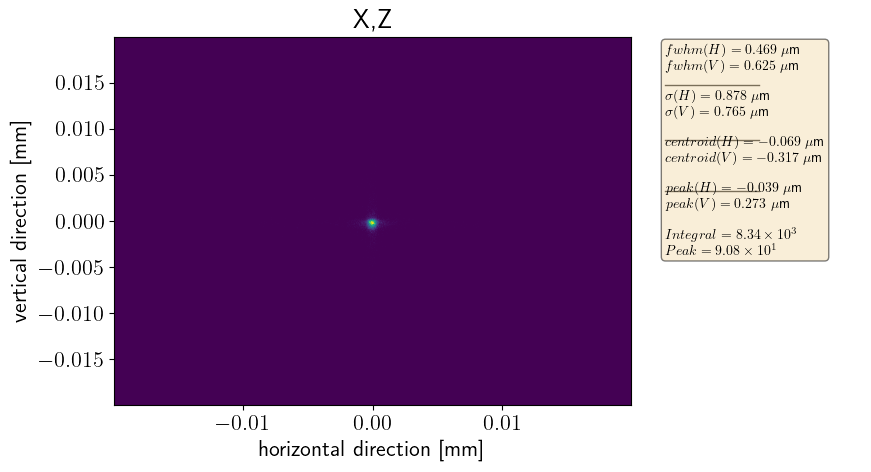

In [16]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [17]:
dw.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.0008785653626669424,
  'h_fwhm': 0.0005371093750000458,
  'h_centroid': -6.853201422490091e-05,
  'h_peak': -7.324218750000104e-05,
  'v_sigma': 0.000764341520108446,
  'v_fwhm': 0.0006835937500000583,
  'v_centroid': -0.0003168719734466379,
  'v_peak': 0.00021972656249999965,
  'integral_intensity': 8337.701904141451,
  'peak_intensity': 46.08654799951838,
  'gaussian_fit': {}}}

In [18]:
save_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi')

In [19]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi/focused_beam.joblib']

In [20]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID


In [21]:
m2 = apu.CMAP

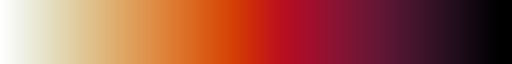

In [22]:
m2

In [23]:
maxcount = hist.data_2D.max()

In [24]:
maxcount

46.08654799951838

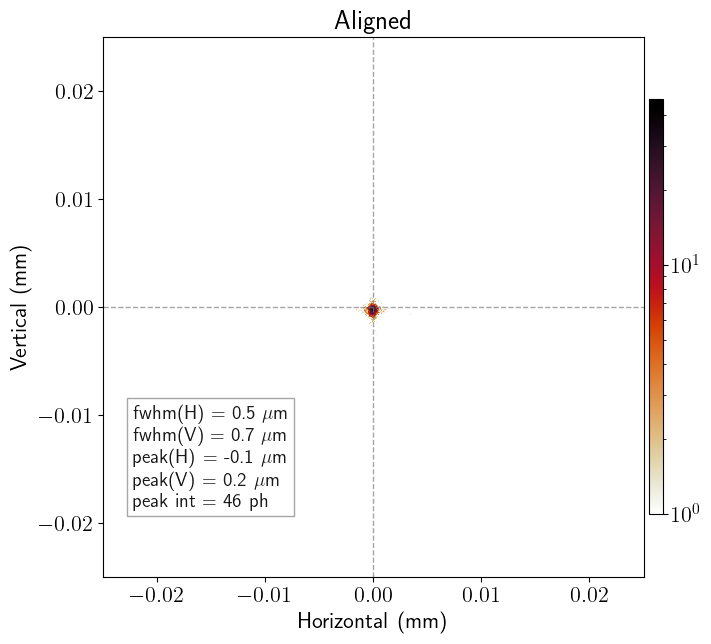

In [25]:
dwd = dw._DictionaryWrapper__dictionary

plt.figure(figsize=[7,7], constrained_layout=True)


plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(1, maxcount))
#plt.xlim(-0.025,0.025)
#plt.ylim(-0.025,0.025)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Aligned")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

(-0.02, 0.02)

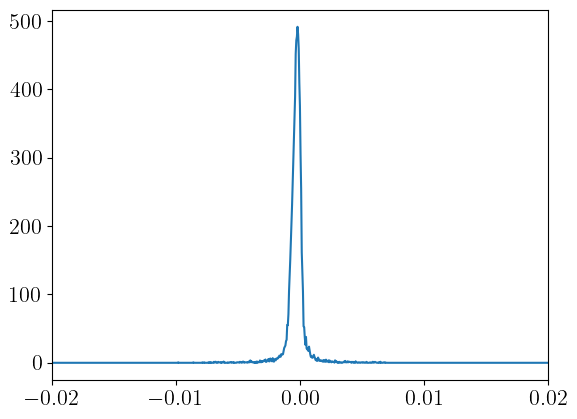

In [26]:
plt.plot(hist.hh, hist.data_2D.sum(axis=0))
plt.xlim([-0.02,0.02])

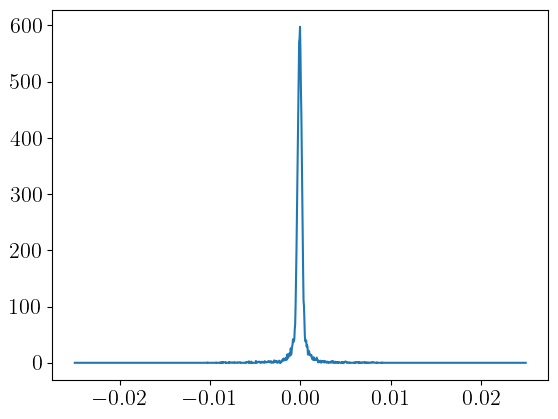

In [27]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [28]:
(hist.data_2D.sum(axis=1).max() + hist.data_2D.sum(axis=0).max()) / 2

544.4880272247146

In [29]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 8.694e-04
Focused beam system peak_distance: 2.316e-04


In [30]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_trans': 0.0, 'vb_trans': 0.0, 'hb_pitch': 3.0000000000000506, 'vb_pitch': 3.0000000000000506, 'hb_1': 215.5, 'hb_2': 112.50000000000001, 'vb_1': 143.99999999999997, 'vb_2': 231.5}


In [31]:
random_move_ranges = {k: np.array(v) * 0.5 for k,v in opt_params.move_motors_ranges.items()}
random_move_ranges

{'hb_trans': array([-10.,  10.]),
 'vb_trans': array([-10.,  10.]),
 'hb_pitch': array([-0.01,  0.01]),
 'vb_pitch': array([-0.01,  0.01]),
 'hb_1': array([-15.,  15.]),
 'hb_2': array([-15.,  15.]),
 'vb_1': array([-15.,  15.]),
 'vb_2': array([-15.,  15.])}

In [32]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=random_move_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', 'vb_1', 'vb_2'] [9.089436379296334, -5.806764266856732, 3.006981317008028, 2.9930186829920733, 215.88410000000002, 101.5776, 149.6711, 241.75239999999994]
Random initialization is (RELATIVE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', 'vb_1', 'vb_2'] [9.

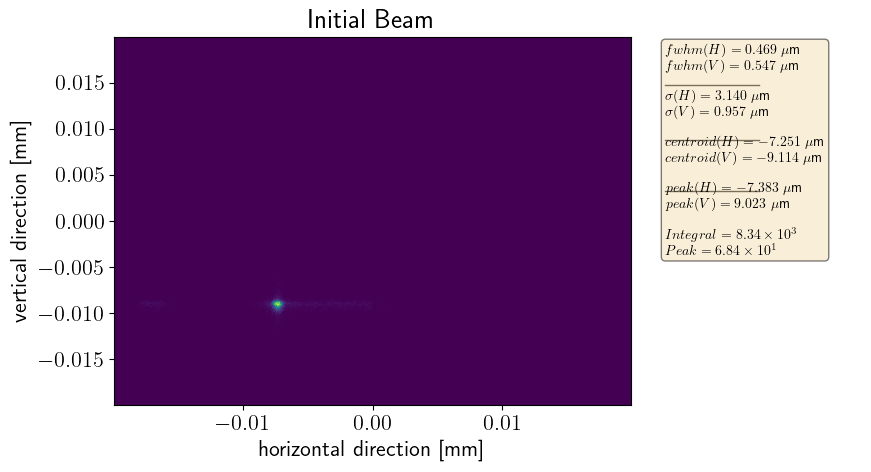

Perturbed beam system fwhm: 7.949e-04
Perturbed beam system peak_distance: 1.177e-02


In [33]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [34]:
hist_pert.data_2D.max()

31.521158973653204

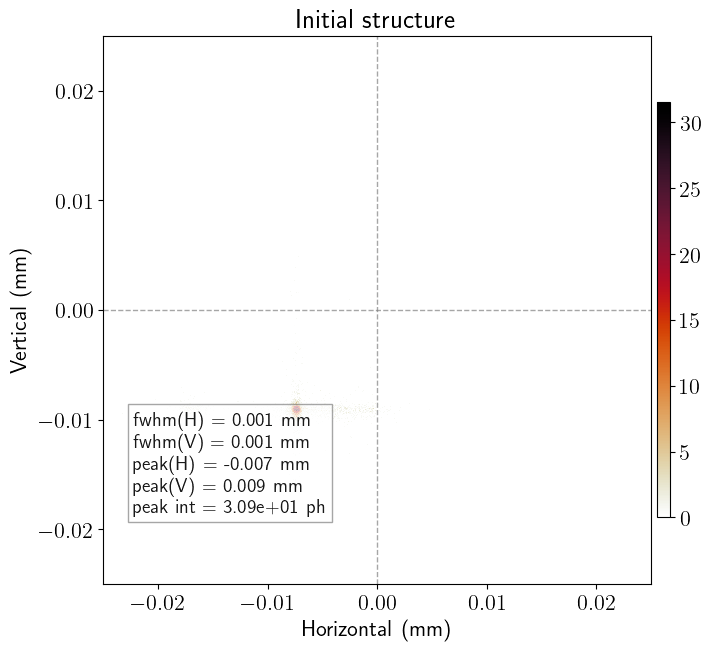

In [35]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
#plt.xlim(-0.05,0.05)
#plt.ylim(-0.05,0.05)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

In [36]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

In [37]:
perturbed_positions

array([  9.12003419,  -5.8463638 ,   3.0065689 ,   2.99298564,
       215.88413849, 101.57758812, 149.67109439, 241.75243173])

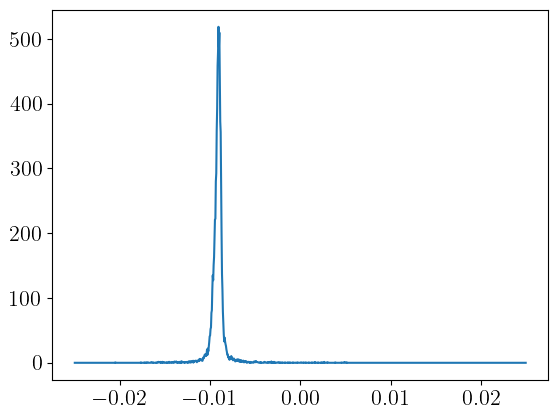

In [38]:
plt.plot(hist_pert.hh, hist_pert.data_2D.sum(axis=0))
#plt.xlim([-0.02,0.02])

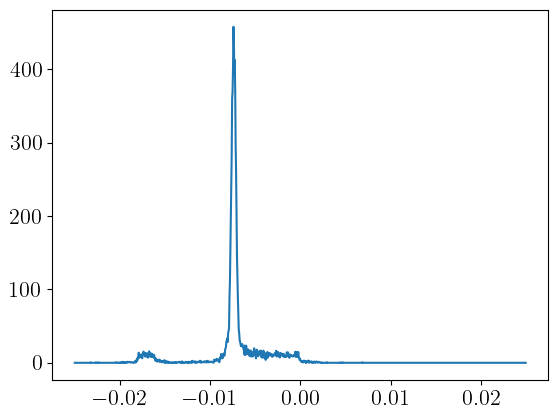

In [39]:
plt.plot(hist_pert.vv, hist_pert.data_2D.sum(axis=1))

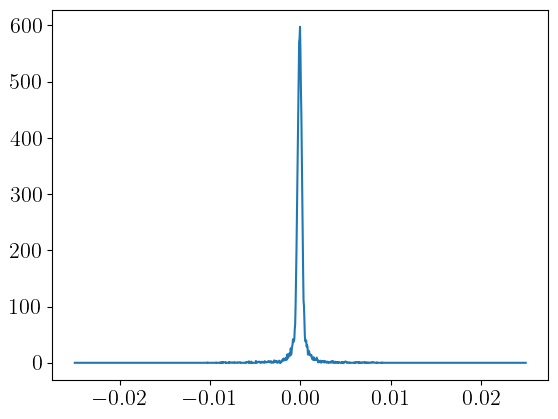

In [40]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [41]:
hist.data_2D.sum()

8337.701904141453

#### Calculating without removing noise : two step optimization

In [43]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

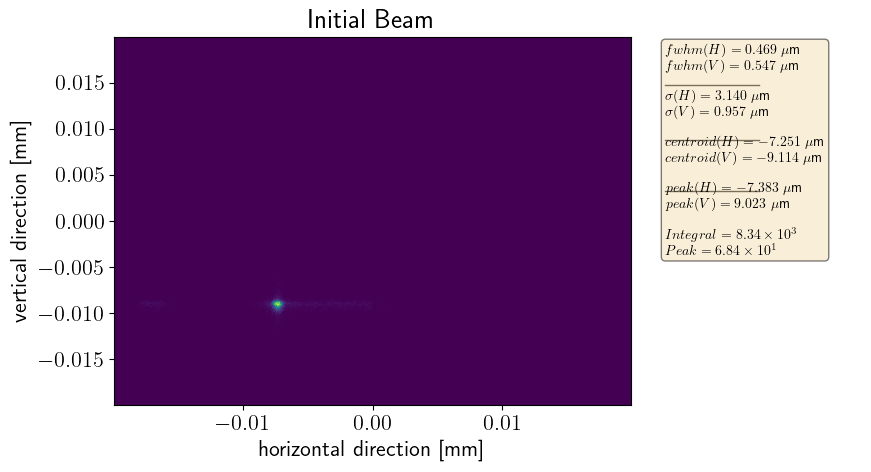

In [44]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [45]:
hist_pert.data_2D.max()

31.521158973652856

In [46]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 7.949e-04
Perturbed beam system peak_distance: 1.177e-02


In [47]:
opt_params = OptimizationParameters()

In [48]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [49]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [50]:
attribs_init

{'fwhm': 0.0007948642869189987, 'peak_distance': 0.01177036363232808}

In [51]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-08-04 15:51:01,088] A new study created in memory with name: no-name-e71486f6-2b0c-44ff-acbf-90d4abc58987


In [52]:
opt_trial.trials(50, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline34IDC/optimization/optuna_botorch.py:316: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

Pruning trial with parameters [10.8, -19.2, 0.0045000000000000005, 0.009750000000000002, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:51:18,899] Trial 2 pruned. 


Pruning trial with parameters [-0.09999999999999787, -11.1, -0.013000000000000001, 0.009750000000000002, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:51:26,143] Trial 3 pruned. 


Pruning trial with parameters [-13.3, -16.5, 0.006249999999999999, 0.016749999999999998, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:51:33,378] Trial 4 finished with values: [0.0011357132177357422, 0.016878612272972937] and parameters: {'hb_trans': -19.9, 'vb_trans': 0.40000000000000213, 'hb_pitch': 0.0115, 'vb_pitch': 0.0045000000000000005, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:51:40,786] Trial 5 pruned. 


Pruning trial with parameters [8.8, -8.399999999999999, 0.016749999999999998, 0.008, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:51:46,423] Trial 6 finished with values: [0.013046250014270134, 0.02311404510004341] and parameters: {'hb_trans': 1.7000000000000028, 'vb_trans': -14.399999999999999, 'hb_pitch': -0.006, 'vb_pitch': 0.006249999999999999, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:51:52,900] Trial 7 finished with values: [0.0007595873626028013, 0.012293686566094645] and parameters: {'hb_trans': -2.3999999999999986, 'vb_trans': -2.6999999999999993, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0007500000000000007, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:52:00,061] Trial 8 pruned. 


Pruning trial with parameters [6.0, 4.0, 0.0115, -0.0007500000000000007, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:52:06,985] Trial 9 pruned. 


Pruning trial with parameters [16.300000000000004, -7.299999999999999, -0.0165, -0.0095, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:52:13,198] Trial 10 finished with values: [0.0010449675077653575, 0.007554091263352826] and parameters: {'hb_trans': -15.5, 'vb_trans': 13.100000000000001, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:52:18,982] Trial 11 finished with values: [0.0010563138502336807, 0.015889372619669544] and parameters: {'hb_trans': 1.9000000000000021, 'vb_trans': 12.700000000000003, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:52:25,037] Trial 12 finished with values: [0.0008693600495491393, 0.00892667068958073] and parameters: {'hb_trans': -6.0, 'vb_trans': 10.100000000000001, 'hb_pitch': -0.0095, 'vb_pitch': 0.015000000000000003, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:52:32,717] Trial 13 pruned. 


Pruning trial with parameters [-7.0, -13.399999999999999, -0.00425, -0.0165, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:52:39,016] Trial 14 pruned. 


Pruning trial with parameters [12.800000000000004, -14.0, -0.006, 0.016749999999999998, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:52:47,423] Trial 15 pruned. 


Pruning trial with parameters [19.5, -1.8000000000000007, 0.013250000000000001, -0.01125, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-04 15:52:53,290] Trial 16 finished with values: [0.0012010130738525284, 0.024308487548792293] and parameters: {'hb_trans': 3.8000000000000007, 'vb_trans': 16.1, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:53:00,338] Trial 17 finished with values: [0.023346023060796025, 0.019250701148404964] and parameters: {'hb_trans': -18.5, 'vb_trans': -5.799999999999999, 'hb_pitch': -0.01825, 'vb_pitch': -0.00775, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-04 15:53:07,080] Trial 18 finished with values: [0.0010563138502336807, 0.005154201216133456] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': 10.900000000000002, 'hb_pitch': -0.02, 'vb_pitch': -0.00425, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWa

Pruning trial with parameters [-13.0, 19.1, -0.01825, -0.01825, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-08-04 15:56:17,506] Trial 35 finished with values: [0.0007

Pruning trial with parameters [18.0, -8.6, 0.016749999999999998, 0.013250000000000001, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-08-04 15:59:03,853] Trial 48 finished with values: [0.0008315130061488209, 0.005625309405824259] and parameters: {'hb_trans': 1.2000000000000028, 'vb_trans': 2.5, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0185, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

In [53]:
opt_trial.trials(75)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:08:22,041] Trial 50 finished with values: [0.0009328600182883022, 0.0026450696028148947] and parameters: {'hb_trans': -9.2, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.006, 'vb_pitch': 0.008, 'hb_1': 1.865000000000002, 'hb_2': -8.232299999999999, 'vb_1': -17.1424, 'vb_2': 0.3387000000000029}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:08:34,258] Trial 51 finished with values: [0.001139904055657202, 0.005204835352863243] and parameters: {'hb_trans': -7.5, 'vb_trans': 9.100000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.006249999999999999, 'hb_1': 12.780000000000001, 'hb_2': -0.12289999999999779, 'vb_1': -19.5206, 'vb_2': 0.9771999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:08:46,387] Trial 52 finished with values: [0.00164138049941143, 0.002762351647445616] and parameters: {'hb_trans': -3.3999999999999986, 'vb_trans': -1.5999999999999979, 'hb_pitch': 0.008, 'vb_pitch': 0.0185, 'hb_1': -15.0894, 'hb_2': -0.6560999999999986, 'vb_1': -14.589699999999999, 'vb_2': -5.373199999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:08:59,262] Trial 53 finished with values: [0.002039122365021766, 0.006374361642030029] and parameters: {'hb_trans': -5.0, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': -20.650199999999998, 'hb_2': -4.266399999999997, 'vb_1': -23.906399999999998, 'vb_2': 0.21649999999999991}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:09:12,010] Trial 54 finished with values: [0.0012900239075804719, 0.0045314236311695755] and parameters: {'hb_trans': -5.1, 'vb_trans': 5.0, 'hb_pitch': -0.00775, 'vb_pitch': 0.0115, 'hb_1': -16.330199999999998, 'hb_2': 8.454999999999998, 'vb_1': -20.423000000000002, 'vb_2': 7.3075000000000045}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:09:22,584] Trial 55 finished with values: [0.0009003461384075852, 0.005253620352641822] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 10.600000000000001, 'hb_pitch': -0.01125, 'vb_pitch': 0.0045000000000000005, 'hb_1': 4.156100000000002, 'hb_2': 11.026299999999999, 'vb_1': -25.7072, 'vb_2': -2.315299999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:09:35,202] Trial 56 finished with values: [0.0009082556268427666, 0.00228946117275394] and parameters: {'hb_trans': -8.0, 'vb_trans': 9.3, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.006, 'hb_1': -11.372699999999998, 'hb_2': 8.516300000000001, 'vb_1': -11.1832, 'vb_2': 6.322600000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:09:48,858] Trial 57 finished with values: [0.0010018693617521942, 0.0022282430095907496] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 8.400000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': 4.676700000000004, 'hb_2': 14.8906, 'vb_1': -12.9662, 'vb_2': -6.5366}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:10:02,231] Trial 58 finished with values: [0.0009379576519677824, 0.0019813030825462387] and parameters: {'hb_trans': -9.1, 'vb_trans': 10.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0007500000000000007, 'hb_1': -19.066899999999997, 'hb_2': 11.8478, 'vb_1': -7.677199999999999, 'vb_2': -17.2397}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:10:13,988] Trial 59 finished with values: [0.0013566839833448231, 0.00014235722399524712] and parameters: {'hb_trans': -9.5, 'vb_trans': 8.900000000000002, 'hb_pitch': -0.0095, 'vb_pitch': -0.0007500000000000007, 'hb_1': -17.5571, 'hb_2': 1.8616000000000028, 'vb_1': -11.926199999999998, 'vb_2': -12.529999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:10:30,504] Trial 60 finished with values: [0.0028345557175197713, 0.003735431346165922] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': 6.300000000000001, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.00425, 'hb_1': -1.3101999999999983, 'hb_2': 12.738, 'vb_1': -25.8456, 'vb_2': -22.9175}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:10:41,886] Trial 61 finished with values: [0.0012816801512116997, 0.002353140773441698] and parameters: {'hb_trans': -6.6, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.006249999999999999, 'hb_1': -19.5078, 'hb_2': 15.098200000000006, 'vb_1': 8.398499999999999, 'vb_2': -8.777099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:10:55,823] Trial 62 finished with values: [0.0020037387235043885, 0.003592270256240762] and parameters: {'hb_trans': -3.0, 'vb_trans': 4.100000000000001, 'hb_pitch': 0.0115, 'vb_pitch': 0.0185, 'hb_1': -19.6547, 'hb_2': 9.297899999999998, 'vb_1': 16.528, 'vb_2': -14.5925}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:11:08,597] Trial 63 finished with values: [0.0008008407942801818, 0.0020265142548288226] and parameters: {'hb_trans': -7.5, 'vb_trans': 5.700000000000003, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': -27.8024, 'hb_2': 9.376400000000004, 'vb_1': -27.6524, 'vb_2': -1.5412}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:11:20,885] Trial 64 finished with values: [0.0013327484437458345, 0.003068217331908741] and parameters: {'hb_trans': -9.5, 'vb_trans': 6.900000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.0024999999999999988, 'hb_1': -29.9814, 'hb_2': -1.7715999999999994, 'vb_1': 3.564799999999998, 'vb_2': -3.462799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:11:34,674] Trial 65 finished with values: [0.002665496887491669, 0.004254636367339297] and parameters: {'hb_trans': -2.8000000000000007, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.015000000000000003, 'hb_1': -23.225, 'hb_2': 19.314500000000002, 'vb_1': 8.3979, 'vb_2': 14.896}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:11:49,549] Trial 66 finished with values: [0.0027295751678466556, 0.006168694944435563] and parameters: {'hb_trans': -1.1999999999999993, 'vb_trans': 3.6000000000000014, 'hb_pitch': 0.008, 'vb_pitch': 0.0185, 'hb_1': -27.3301, 'hb_2': -9.037199999999999, 'vb_1': -6.3977, 'vb_2': -0.3722999999999992}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:12:04,177] Trial 67 finished with values: [0.0017914000320161823, 0.0032493640570906627] and parameters: {'hb_trans': -2.599999999999998, 'vb_trans': 2.5, 'hb_pitch': 0.008, 'vb_pitch': 0.016749999999999998, 'hb_1': 16.923700000000004, 'hb_2': 18.070800000000006, 'vb_1': -12.2542, 'vb_2': 14.694400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:12:18,655] Trial 68 finished with values: [0.0011241078548068673, 0.0029831147254113133] and parameters: {'hb_trans': -6.5, 'vb_trans': 9.700000000000003, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -9.790299999999998, 'hb_2': 2.594999999999999, 'vb_1': -11.7426, 'vb_2': -6.849799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:12:33,288] Trial 69 finished with values: [0.000988694176333902, 0.0006668213029173665] and parameters: {'hb_trans': -3.3999999999999986, 'vb_trans': 4.200000000000003, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.008, 'hb_1': 0.3439000000000014, 'hb_2': 17.386400000000002, 'vb_1': -14.2654, 'vb_2': -14.7182}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:12:46,330] Trial 70 finished with values: [0.0014058769578993355, 0.0023753264353428304] and parameters: {'hb_trans': -3.5, 'vb_trans': 6.400000000000002, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.006249999999999999, 'hb_1': -21.966099999999997, 'hb_2': 15.589400000000005, 'vb_1': -8.523299999999999, 'vb_2': 3.1122000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:13:01,220] Trial 71 finished with values: [0.0029877067462460273, 0.0038541756019832376] and parameters: {'hb_trans': -7.799999999999999, 'vb_trans': 4.0, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.016749999999999998, 'hb_1': 6.4589, 'hb_2': 4.310400000000001, 'vb_1': -25.4985, 'vb_2': -24.467}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:13:12,097] Trial 72 finished with values: [0.0012448778109358447, 0.0013233232649284804] and parameters: {'hb_trans': -6.199999999999999, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.6715000000000018, 'hb_2': 23.184800000000003, 'vb_1': -4.3028999999999975, 'vb_2': 7.745899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:13:24,759] Trial 73 finished with values: [0.0015254393898256485, 0.0014862530522680105] and parameters: {'hb_trans': -10.1, 'vb_trans': 11.3, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': -17.5106, 'hb_2': 29.093500000000006, 'vb_1': -0.8218999999999994, 'vb_2': 5.705200000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:13:38,725] Trial 74 finished with values: [0.0012448778109358447, 0.003894176899391563] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': -2.3000000000000007, 'hb_pitch': 0.0185, 'vb_pitch': 0.016749999999999998, 'hb_1': 11.8414, 'hb_2': 12.189700000000002, 'vb_1': -10.572699999999998, 'vb_2': -24.658}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:13:50,534] Trial 75 finished with values: [0.0008315130061488209, 0.004516667545970724] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 4.5, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': -5.4114, 'hb_2': 29.7395, 'vb_1': -11.538799999999998, 'vb_2': -4.266099999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:14:04,124] Trial 76 finished with values: [0.00164138049941143, 0.005267217287824124] and parameters: {'hb_trans': -10.0, 'vb_trans': 6.5, 'hb_pitch': 0.008, 'vb_pitch': 0.009750000000000002, 'hb_1': -7.299799999999998, 'hb_2': 21.131800000000005, 'vb_1': -17.963, 'vb_2': -13.032}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:14:16,308] Trial 77 finished with values: [0.0011241078548068673, 0.004081896912038898] and parameters: {'hb_trans': -2.6999999999999993, 'vb_trans': 1.1000000000000014, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.008, 'hb_1': 4.144300000000001, 'hb_2': 8.035600000000002, 'vb_1': -1.8395999999999972, 'vb_2': -13.5806}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:14:30,192] Trial 78 finished with values: [0.002069298837931533, 0.001798373716865517] and parameters: {'hb_trans': -5.899999999999999, 'vb_trans': 3.900000000000002, 'hb_pitch': 0.0115, 'vb_pitch': 0.013250000000000001, 'hb_1': 27.2982, 'hb_2': 22.923500000000004, 'vb_1': 20.1612, 'vb_2': -5.052699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:14:43,899] Trial 79 finished with values: [0.001717334511237351, 0.0015704904332104887] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': 10.900000000000002, 'hb_pitch': -0.02, 'vb_pitch': -0.00425, 'hb_1': -14.398299999999999, 'hb_2': -10.233999999999998, 'vb_1': -13.1293, 'vb_2': 0.35970000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:15:00,709] Trial 80 finished with values: [0.003384320986555651, 0.0023692964029319516] and parameters: {'hb_trans': -5.399999999999999, 'vb_trans': 6.900000000000002, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': 25.3296, 'hb_2': 28.2436, 'vb_1': -24.3572, 'vb_2': -16.3738}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:15:14,597] Trial 81 finished with values: [0.0013566839833448231, 0.0023863419205639464] and parameters: {'hb_trans': -6.699999999999999, 'vb_trans': 2.700000000000003, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.009750000000000002, 'hb_1': 21.344, 'hb_2': 14.998400000000004, 'vb_1': -29.1881, 'vb_2': -3.0595999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:15:26,764] Trial 82 finished with values: [0.0011799849583589454, 0.0022706390671067226] and parameters: {'hb_trans': -4.1, 'vb_trans': 2.900000000000002, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.008, 'hb_1': 11.784800000000004, 'hb_2': 9.7468, 'vb_1': 0.6960000000000015, 'vb_2': 0.5139000000000031}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:15:39,424] Trial 83 finished with values: [0.0008008407942801818, 0.003957940466943403] and parameters: {'hb_trans': -8.7, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.00425, 'vb_pitch': -0.0007500000000000007, 'hb_1': 6.4632000000000005, 'hb_2': 10.747100000000003, 'vb_1': -4.997799999999998, 'vb_2': -2.2982999999999976}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:15:55,479] Trial 84 finished with values: [0.0008638577154763496, 0.002740689207953855] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 5.400000000000002, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': -8.2564, 'hb_2': 12.846200000000003, 'vb_1': -9.404799999999998, 'vb_2': -13.2695}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:16:09,575] Trial 85 finished with values: [0.001205965726096633, 0.0015336229272011146] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': 9.3, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -28.9374, 'hb_2': 17.307700000000004, 'vb_1': 5.530200000000001, 'vb_2': 4.7402000000000015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:16:25,320] Trial 86 finished with values: [0.0010300304252798234, 0.001328717267987088] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 8.600000000000001, 'hb_pitch': 0.008, 'vb_pitch': -0.0007500000000000007, 'hb_1': -14.8567, 'hb_2': 25.9082, 'vb_1': -10.323899999999998, 'vb_2': -4.077499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:16:42,707] Trial 87 finished with values: [0.0008315130061488209, 0.0028263429538535924] and parameters: {'hb_trans': -13.5, 'vb_trans': 10.700000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.006, 'hb_1': 3.549900000000001, 'hb_2': 10.670300000000005, 'vb_1': -7.7913, 'vb_2': -27.3256}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:16:59,674] Trial 88 finished with values: [0.0012900239075804719, 0.001779716500840586] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': 8.3, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': -9.264299999999999, 'hb_2': -1.2180999999999997, 'vb_1': -6.312799999999999, 'vb_2': 3.4618000000000038}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:17:16,139] Trial 89 finished with values: [0.0009480706952611941, 0.0026594524152629335] and parameters: {'hb_trans': -7.0, 'vb_trans': 5.100000000000001, 'hb_pitch': 0.0115, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.5778999999999996, 'hb_2': 19.3714, 'vb_1': -23.7432, 'vb_2': -2.2271}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:17:38,310] Trial 90 finished with values: [0.0015191747252056027, 0.00036046931299397994] and parameters: {'hb_trans': -7.0, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0010000000000000009, 'hb_1': 13.607500000000002, 'hb_2': 11.018700000000003, 'vb_1': -24.4396, 'vb_2': 13.158900000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:17:55,258] Trial 91 finished with values: [0.0021221986144631427, 0.0022716888309478756] and parameters: {'hb_trans': -4.399999999999999, 'vb_trans': 2.1000000000000014, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.016749999999999998, 'hb_1': 10.211200000000005, 'hb_2': 4.066700000000004, 'vb_1': 29.245800000000003, 'vb_2': -20.575499999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:18:10,537] Trial 92 finished with values: [0.0016164985700437755, 0.003936195036188506] and parameters: {'hb_trans': -11.6, 'vb_trans': 10.600000000000001, 'hb_pitch': -0.00775, 'vb_pitch': -0.0095, 'hb_1': -20.2002, 'hb_2': 18.6802, 'vb_1': 8.7896, 'vb_2': -17.6039}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:18:25,730] Trial 93 finished with values: [0.0012900239075804719, 0.0017823937742621077] and parameters: {'hb_trans': -10.0, 'vb_trans': 8.200000000000003, 'hb_pitch': -0.006, 'vb_pitch': -0.0007500000000000007, 'hb_1': -8.0857, 'hb_2': 20.803000000000004, 'vb_1': 1.4491000000000014, 'vb_2': -14.632399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:18:43,821] Trial 94 finished with values: [0.003134522235489336, 0.0038256142615466886] and parameters: {'hb_trans': -8.1, 'vb_trans': 9.400000000000002, 'hb_pitch': -0.01825, 'vb_pitch': -0.0007500000000000007, 'hb_1': 21.968400000000003, 'hb_2': 15.760100000000001, 'vb_1': -27.9776, 'vb_2': -23.617}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:19:00,320] Trial 95 finished with values: [0.0012323661586059608, 0.0029176592273295536] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 8.100000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.00425, 'hb_1': -28.4747, 'hb_2': 27.729400000000005, 'vb_1': -11.720599999999997, 'vb_2': -14.165899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:19:21,955] Trial 96 finished with values: [0.0009765625000000833, 0.0028839611876649808] and parameters: {'hb_trans': -4.699999999999999, 'vb_trans': 2.8000000000000007, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.006249999999999999, 'hb_1': -3.4406, 'hb_2': 25.292, 'vb_1': 1.1522000000000006, 'vb_2': 5.122}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:19:39,604] Trial 97 finished with values: [0.0014850494458737153, 0.002520448975909082] and parameters: {'hb_trans': -12.5, 'vb_trans': 10.5, 'hb_pitch': -0.01475, 'vb_pitch': -0.0007500000000000007, 'hb_1': 15.6284, 'hb_2': 11.051900000000003, 'vb_1': -25.6142, 'vb_2': 18.7868}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:19:54,640] Trial 98 finished with values: [0.0007948642869189987, 0.0014054529262328371] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': 5.5, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': -3.2997999999999976, 'hb_2': 29.454, 'vb_1': -7.561999999999998, 'vb_2': -23.7387}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:20:13,647] Trial 99 finished with values: [0.0011523851290241164, 0.000865925188035558] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 6.200000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.002749999999999999, 'hb_1': 8.125300000000003, 'hb_2': -18.272100000000002, 'vb_1': -24.301299999999998, 'vb_2': 7.036900000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:20:33,296] Trial 100 finished with values: [0.0016701788453602079, 0.0032228411997117655] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': -1.5, 'hb_pitch': 0.008, 'vb_pitch': 0.0185, 'hb_1': -14.0984, 'hb_2': 13.8491, 'vb_1': 26.841300000000004, 'vb_2': -13.0745}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:20:48,705] Trial 101 finished with values: [0.0017263349150063668, 0.0020370751997073385] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 5.300000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0115, 'hb_1': 9.084299999999999, 'hb_2': 20.3046, 'vb_1': 2.791499999999999, 'vb_2': -19.0844}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:21:03,210] Trial 102 finished with values: [0.0010054326309558476, 0.0009193442570196634] and parameters: {'hb_trans': -7.1, 'vb_trans': 2.3000000000000007, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0115, 'hb_1': 2.439399999999999, 'hb_2': 26.640900000000002, 'vb_1': -12.093399999999999, 'vb_2': 3.9883000000000024}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:21:16,098] Trial 103 finished with values: [0.00103580094900382, 0.0018377157486873844] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 9.0, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': 19.693800000000003, 'hb_2': 2.5075000000000003, 'vb_1': -15.8881, 'vb_2': -24.9207}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:21:33,067] Trial 104 finished with values: [0.0020449601163450887, 0.0020382452602286908] and parameters: {'hb_trans': -12.1, 'vb_trans': 9.700000000000003, 'hb_pitch': -0.01825, 'vb_pitch': -0.006, 'hb_1': -16.5874, 'hb_2': -6.9263999999999974, 'vb_1': -18.098300000000002, 'vb_2': -25.7375}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:21:48,869] Trial 105 finished with values: [0.0007627196949128243, 0.0001244877810935739] and parameters: {'hb_trans': -2.8000000000000007, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': -3.0619999999999976, 'hb_2': 9.326300000000003, 'vb_1': -5.336599999999997, 'vb_2': -4.588999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:22:05,572] Trial 106 finished with values: [0.0012246031449204612, 0.001693216883242159] and parameters: {'hb_trans': -6.299999999999999, 'vb_trans': 7.5, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': 20.037200000000006, 'hb_2': -9.6679, 'vb_1': -11.2515, 'vb_2': -0.5300999999999974}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:22:22,777] Trial 107 finished with values: [0.0010300304252798234, 0.0030821726564716923] and parameters: {'hb_trans': -8.7, 'vb_trans': 2.400000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0185, 'hb_1': 16.1822, 'hb_2': 8.2074, 'vb_1': -18.176000000000002, 'vb_2': 1.4548000000000023}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:22:41,848] Trial 108 finished with values: [0.0012448778109358447, 0.0006108396485935939] and parameters: {'hb_trans': -10.7, 'vb_trans': 11.200000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.00425, 'hb_1': -22.0717, 'hb_2': 3.1345000000000027, 'vb_1': -9.892699999999998, 'vb_2': 18.323300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:23:01,348] Trial 109 finished with values: [0.0024281868670229328, 0.0018876349394607124] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 13.0, 'hb_pitch': -0.006, 'vb_pitch': -0.006, 'hb_1': 0.6108000000000011, 'hb_2': 2.434899999999999, 'vb_1': -24.4262, 'vb_2': -16.386400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:23:18,303] Trial 110 finished with values: [0.0012010130738525284, 0.002624256210309624] and parameters: {'hb_trans': -8.6, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.006249999999999999, 'hb_1': -7.982899999999997, 'hb_2': 11.575099999999999, 'vb_1': -22.0826, 'vb_2': 15.991600000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:23:36,128] Trial 111 finished with values: [0.0012323661586059608, 0.0022121350175926353] and parameters: {'hb_trans': -5.299999999999999, 'vb_trans': 8.3, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': 3.3537999999999997, 'hb_2': -18.6017, 'vb_1': -2.5710999999999977, 'vb_2': 27.614800000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:23:54,498] Trial 112 finished with values: [0.0008008407942801818, 0.0020276904094576297] and parameters: {'hb_trans': -4.6, 'vb_trans': 6.700000000000003, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': 1.0694000000000017, 'hb_2': 24.844900000000003, 'vb_1': -8.728299999999997, 'vb_2': 5.108800000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:24:12,883] Trial 113 finished with values: [0.0012477472987482154, 0.0019485419862534104] and parameters: {'hb_trans': -4.1, 'vb_trans': 2.400000000000002, 'hb_pitch': 0.0185, 'vb_pitch': 0.009750000000000002, 'hb_1': 5.809400000000004, 'hb_2': -1.629299999999997, 'vb_1': -26.2236, 'vb_2': 13.300699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:24:32,965] Trial 114 finished with values: [0.0007627196949128243, 0.004910201504179387] and parameters: {'hb_trans': -2.0, 'vb_trans': 7.100000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.013250000000000001, 'hb_1': 0.35320000000000107, 'hb_2': -14.8201, 'vb_1': 16.92, 'vb_2': 1.8636000000000017}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:24:54,302] Trial 115 finished with values: [0.0013147375017419343, 0.00032572422031558555] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': 9.900000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': -10.7085, 'hb_2': -6.93, 'vb_1': -6.770199999999999, 'vb_2': 17.4471}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:25:22,399] Trial 116 finished with values: [0.0010018693617521942, 0.002535538795892036] and parameters: {'hb_trans': -0.5999999999999979, 'vb_trans': 3.6000000000000014, 'hb_pitch': 0.0185, 'vb_pitch': 0.008, 'hb_1': 3.406100000000002, 'hb_2': 27.809000000000005, 'vb_1': -1.6437999999999988, 'vb_2': -6.785899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:25:44,640] Trial 117 finished with values: [0.0014850494458737153, 0.0010836104014244213] and parameters: {'hb_trans': -3.5, 'vb_trans': 10.700000000000003, 'hb_pitch': 0.0185, 'vb_pitch': -0.0007500000000000007, 'hb_1': -25.3765, 'hb_2': 24.302400000000006, 'vb_1': 28.689300000000003, 'vb_2': -13.6419}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:26:06,493] Trial 118 finished with values: [0.0013758791800397043, 0.0008957000160080148] and parameters: {'hb_trans': -3.5, 'vb_trans': 7.400000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.002749999999999999, 'hb_1': 14.469900000000003, 'hb_2': -28.7662, 'vb_1': -13.349799999999998, 'vb_2': 10.452800000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:26:32,106] Trial 119 finished with values: [0.002018557285995718, 0.0009549612898246078] and parameters: {'hb_trans': -2.6999999999999993, 'vb_trans': 8.900000000000002, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.0024999999999999988, 'hb_1': -22.0884, 'hb_2': 6.608899999999998, 'vb_1': -29.6606, 'vb_2': 14.070300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:26:49,296] Trial 120 finished with values: [0.0019186408891006031, 0.003495391263658416] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 12.5, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -21.0801, 'hb_2': -7.588699999999999, 'vb_1': -11.357299999999999, 'vb_2': -27.3415}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:27:08,909] Trial 121 finished with values: [0.0007595873626028013, 0.002271688830947874] and parameters: {'hb_trans': -3.8999999999999986, 'vb_trans': 4.800000000000001, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.013250000000000001, 'hb_1': -2.4771, 'hb_2': 4.146500000000003, 'vb_1': -7.8592999999999975, 'vb_2': -5.439699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:27:33,745] Trial 122 finished with values: [0.0025353037081539604, 0.0030752029103887565] and parameters: {'hb_trans': -5.899999999999999, 'vb_trans': 6.5, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': -27.4026, 'hb_2': -8.7212, 'vb_1': -17.8119, 'vb_2': 8.938300000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:27:57,532] Trial 123 finished with values: [0.0017605230837228012, 0.0013070076967113449] and parameters: {'hb_trans': -4.6, 'vb_trans': 12.200000000000003, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.006, 'hb_1': 12.762900000000002, 'hb_2': 3.3735, 'vb_1': -29.1867, 'vb_2': 20.057500000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-04 16:28:24,529] Trial 124 finished with values: [0.002085938414384341, 0.001741802634935251] and parameters: {'hb_trans': -3.3999999999999986, 'vb_trans': 9.100000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.00425, 'hb_1': 8.182000000000002, 'hb_2': -3.5056999999999974, 'vb_1': 4.259, 'vb_2': 12.359500000000004}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_59244/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

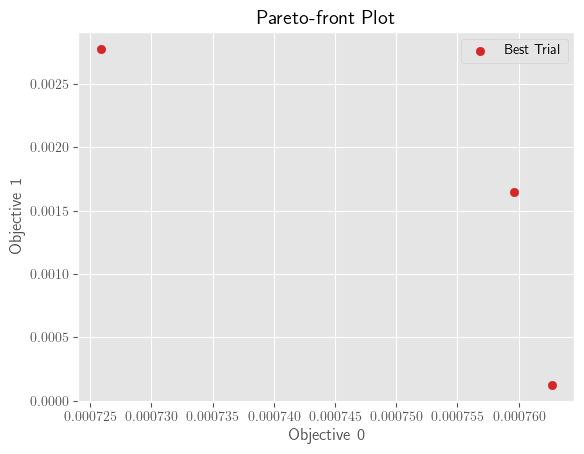

In [54]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [55]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi/trials.joblib']

#### This is the analysis part

In [56]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [57]:
trials_file = save_dir / "trials.joblib"

In [58]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-08-04 16:42:14,938] A new study created in memory with name: no-name-5c5eabe8-8570-49ff-bf9a-f1b96fba45ab


Assuming minimization for all objectives.


In [59]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [60]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

Trial number 44
Trial values: peak_distance 2.777e-03 fwhm 7.259e-04
Trial dw:
{'h_sigma': 0.0010166893437359005, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0004004375790049321, 'h_peak': 0.00031738281250000104, 'v_sigma': 0.001100183093628245, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -0.002781365451110083, 'v_peak': 0.002758789062500001, 'integral_intensity': 8338.26310545328, 'peak_intensity': 43.308447726200214, 'gaussian_fit': {}}
Actual fwhm 0.0007258822630527232


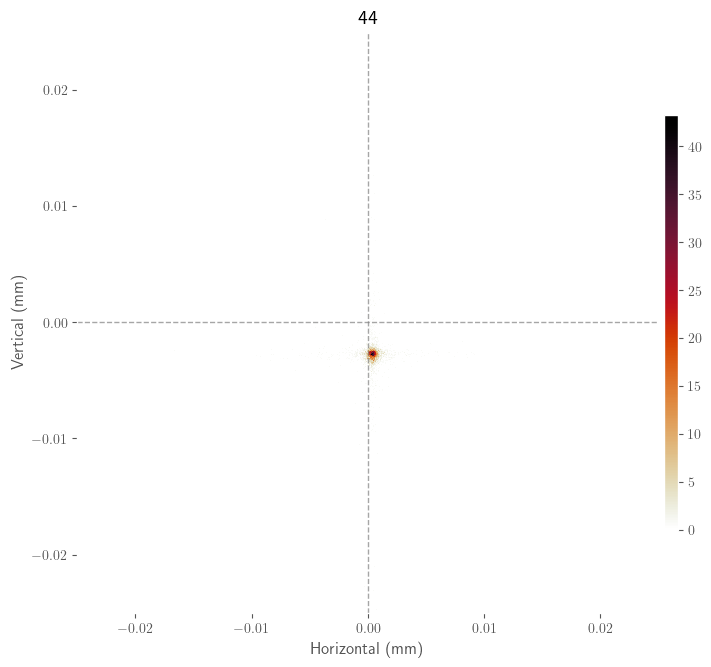

Trial number 46
Trial values: peak_distance 1.650e-03 fwhm 7.596e-04
Trial dw:
{'h_sigma': 0.001061866121083209, 'h_fwhm': 0.0005371093750000458, 'h_centroid': -0.0014407604221311847, 'h_peak': -0.0014404296874999997, 'v_sigma': 0.0009096724975991424, 'v_fwhm': 0.0005371093750000458, 'v_centroid': 0.0006514183005948794, 'v_peak': -0.000805664062500001, 'integral_intensity': 8340.760527281469, 'peak_intensity': 42.764349668379374, 'gaussian_fit': {}}
Actual fwhm 0.0007595873626028013


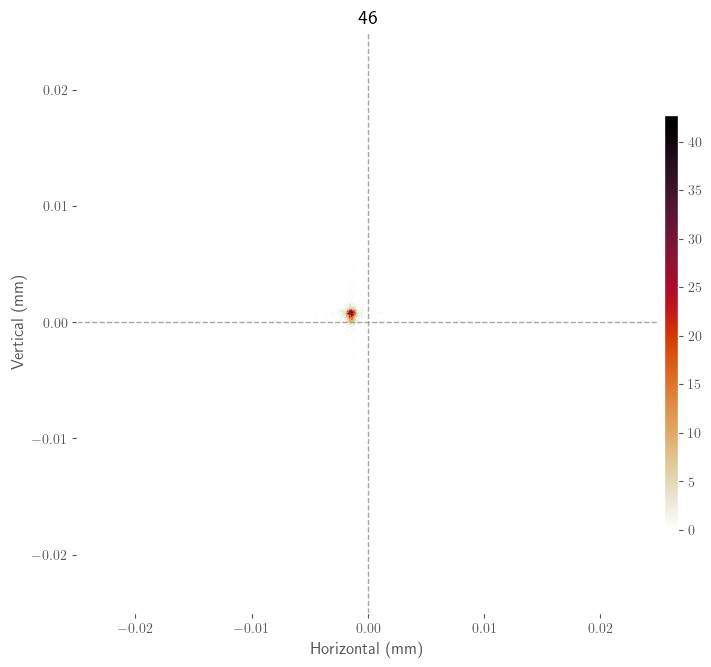

Trial number 105
Trial values: peak_distance 1.245e-04 fwhm 7.627e-04
Trial dw:
{'h_sigma': 0.0011763629219399825, 'h_fwhm': 0.00058593750000005, 'h_centroid': 8.883766404653806e-05, 'h_peak': 0.0001220703125, 'v_sigma': 0.0007385077540939687, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -1.3030733739282036e-05, 'v_peak': -2.4414062500000347e-05, 'integral_intensity': 8342.788241831293, 'peak_intensity': 45.48565582398579, 'gaussian_fit': {}}
Actual fwhm 0.0007627196949128243


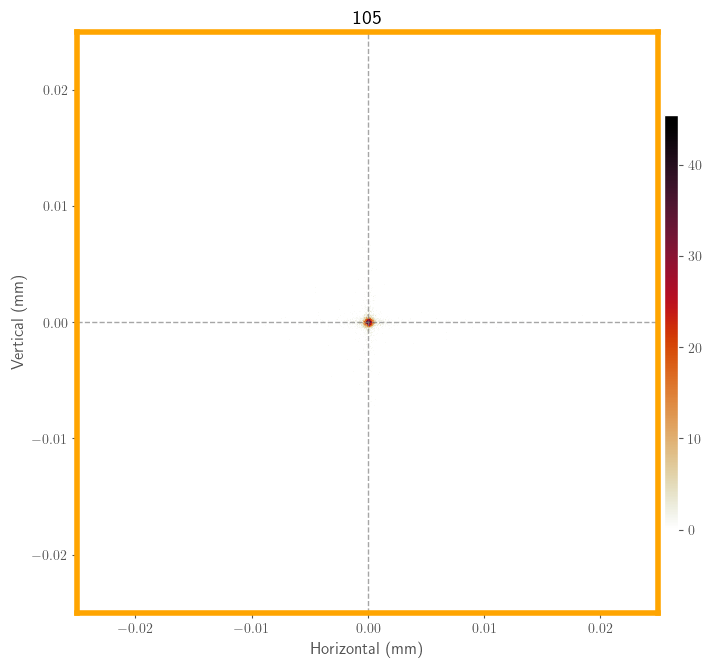

In [61]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

### One step optimization

In [42]:

save_dir = cur_dir / 'nf_fwhm_pl_one_step'
save_dir.mkdir(exist_ok=True)

In [43]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

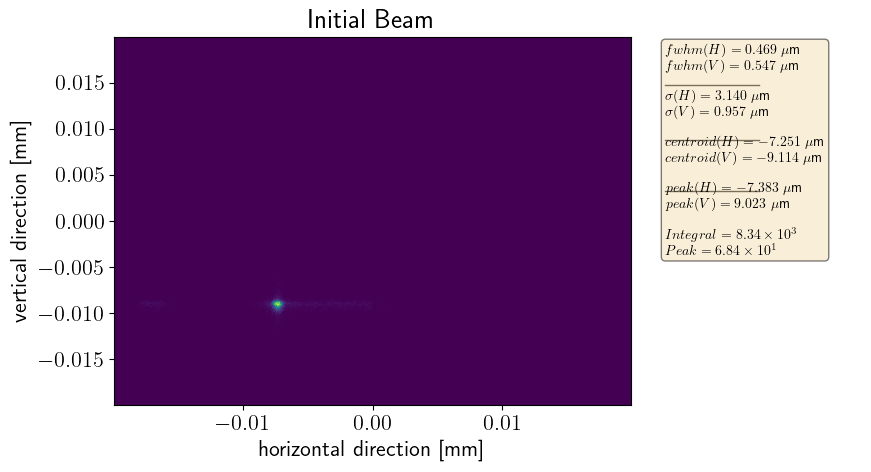

In [44]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [45]:
hist_pert.data_2D.max()

31.521158973652856

In [46]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 7.949e-04
Perturbed beam system peak_distance: 1.177e-02


In [47]:
opt_params = OptimizationParameters()

In [48]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [49]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [50]:
attribs_init

{'fwhm': 0.0007948642869189987, 'peak_distance': 0.01177036363232808}

In [51]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-08-07 16:22:39,096] A new study created in memory with name: no-name-3f4aac35-e22d-455e-8feb-de72699772a3


In [52]:
opt_trial.trials(125)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:22:51,927] Trial 1 pruned. 


Pruning trial with parameters [10.8, -19.2, 0.0045000000000000005, 0.009750000000000002, -0.08959999999999724, -16.5123, -18.1163, 15.631800000000005]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:00,044] Trial 2 pruned. 


Pruning trial with parameters [-13.3, -16.5, 0.006249999999999999, 0.016749999999999998, -29.7632, 0.7315000000000005, 18.757200000000005, 6.7515]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:07,934] Trial 3 pruned. 


Pruning trial with parameters [8.8, -8.399999999999999, 0.016749999999999998, 0.008, 2.552599999999998, -21.4698, -7.599599999999999, 10.448]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:14,661] Trial 4 finished with values: [0.0010483843043743027, 0.012261645406483621] and parameters: {'hb_trans': -2.3999999999999986, 'vb_trans': -2.6999999999999993, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0007500000000000007, 'hb_1': 9.023800000000001, 'hb_2': 6.0623000000000005, 'vb_1': 18.313300000000005, 'vb_2': 1.2988}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:22,119] Trial 5 pruned. 


Pruning trial with parameters [16.300000000000004, -7.299999999999999, -0.0165, -0.0095, -23.161, 19.720800000000004, -27.1863, 7.577200000000005]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:28,245] Trial 6 finished with values: [0.0009480706952611941, 0.016284783622374708] and parameters: {'hb_trans': 1.9000000000000021, 'vb_trans': 12.700000000000003, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': -8.9009, 'hb_2': 15.278800000000004, 'vb_1': -12.2423, 'vb_2': 23.036100000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:36,721] Trial 7 pruned. 


Pruning trial with parameters [-7.0, -13.399999999999999, -0.00425, -0.0165, 19.2663, -20.9309, -6.953199999999999, 26.6556]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:45,175] Trial 8 pruned. 


Pruning trial with parameters [19.5, -1.8000000000000007, 0.013250000000000001, -0.01125, 5.842199999999998, 24.169900000000005, 2.0733999999999995, 5.411999999999999]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:23:52,675] Trial 9 finished with values: [0.0008976941558033107, 0.0193253613456708] and parameters: {'hb_trans': -18.5, 'vb_trans': -5.799999999999999, 'hb_pitch': -0.01825, 'vb_pitch': -0.00775, 'hb_1': -10.1569, 'hb_2': 16.4298, 'vb_1': -27.6025, 'vb_2': -4.230499999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:01,579] Trial 10 finished with values: [0.0010563138502336807, 0.012685590102288744] and parameters: {'hb_trans': -7.5, 'vb_trans': 5.400000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.02, 'hb_1': 22.794900000000005, 'hb_2': 15.794400000000003, 'vb_1': 22.685700000000004, 'vb_2': -4.9495000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:09,716] Trial 11 pruned. 


Pruning trial with parameters [4.200000000000003, 0.5, 0.002749999999999999, -0.0095, -11.9478, -28.4761, -11.816299999999998, -15.475499999999998]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:17,291] Trial 12 finished with values: [0.00253765360550535, 0.014777467207326115] and parameters: {'hb_trans': 2.3000000000000007, 'vb_trans': 2.6000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0095, 'hb_1': -26.145, 'hb_2': 28.729100000000003, 'vb_1': -9.6176, 'vb_2': -0.2970999999999968}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:23,441] Trial 13 pruned. 


Pruning trial with parameters [19.0, -2.3999999999999986, -0.00775, -0.0007500000000000007, 4.688099999999999, 21.236000000000004, -25.9142, -2.1281999999999996]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:32,480] Trial 14 pruned. 


Pruning trial with parameters [11.200000000000003, 8.700000000000003, 0.002749999999999999, -0.02, -8.9607, 3.791400000000003, -12.016299999999998, 0.740000000000002]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:39,577] Trial 15 pruned. 


Pruning trial with parameters [6.900000000000002, -13.7, -0.01825, -0.00775, -23.516199999999998, -19.265900000000002, 23.1496, -8.078199999999999]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:45,709] Trial 16 finished with values: [0.002085938414384341, 0.00603150884043221] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': 10.0, 'hb_pitch': -0.0165, 'vb_pitch': 0.009750000000000002, 'hb_1': -1.812899999999999, 'hb_2': 5.895299999999999, 'vb_1': -21.1428, 'vb_2': -18.958}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:51,533] Trial 17 pruned. 


Pruning trial with parameters [5.800000000000001, -18.1, -0.01125, 0.0010000000000000009, -16.3936, -7.1153999999999975, 25.3339, 25.5214]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:24:59,259] Trial 18 finished with values: [0.00283076817199941, 0.014579631698938235] and parameters: {'hb_trans': 2.6000000000000014, 'vb_trans': 1.3000000000000007, 'hb_pitch': -0.02, 'vb_pitch': 0.0185, 'hb_1': 4.381700000000002, 'hb_2': 17.5054, 'vb_1': 3.693400000000004, 'vb_2': 22.640100000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:06,296] Trial 19 finished with values: [0.001532456526023101, 0.01364625983505964] and parameters: {'hb_trans': 3.3000000000000007, 'vb_trans': 8.3, 'hb_pitch': -0.01475, 'vb_pitch': -0.00425, 'hb_1': 11.633400000000002, 'hb_2': -23.7229, 'vb_1': -3.6236999999999995, 'vb_2': -20.0279}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:12,439] Trial 20 finished with values: [0.0012477472987482154, 0.014807445903256122] and parameters: {'hb_trans': 0.20000000000000284, 'vb_trans': 12.700000000000003, 'hb_pitch': -0.0165, 'vb_pitch': 0.0115, 'hb_1': 3.907499999999999, 'hb_2': 5.360800000000005, 'vb_1': -18.113999999999997, 'vb_2': -3.8329999999999984}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:20,429] Trial 21 finished with values: [0.002502173432679697, 0.015669682510071184] and parameters: {'hb_trans': -16.6, 'vb_trans': 15.300000000000004, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.015000000000000003, 'hb_1': -14.448699999999999, 'hb_2': 5.1554, 'vb_1': -25.8114, 'vb_2': -14.2515}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:28,131] Trial 22 finished with values: [0.0020326814742676193, 0.011109069133255328] and parameters: {'hb_trans': -1.1999999999999993, 'vb_trans': 1.1000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': 21.121500000000005, 'hb_2': 1.4964000000000013, 'vb_1': -0.10689999999999955, 'vb_2': -8.8244}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:36,250] Trial 23 finished with values: [0.0010483843043743027, 0.008223227438036763] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 0.40000000000000213, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': 0.7512000000000008, 'hb_2': 8.327000000000005, 'vb_1': 7.065000000000005, 'vb_2': -9.854}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:44,781] Trial 24 finished with values: [0.0008008407942801818, 0.0067238473407814515] and parameters: {'hb_trans': -0.8999999999999986, 'vb_trans': 8.900000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.008, 'hb_1': -0.6066000000000003, 'hb_2': 6.852499999999999, 'vb_1': 1.7939000000000007, 'vb_2': -5.751099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:25:52,987] Trial 25 finished with values: [0.01882677255418967, 0.0038068718563524667] and parameters: {'hb_trans': 3.6000000000000014, 'vb_trans': 9.900000000000002, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': 0.2700000000000031, 'hb_2': 0.030700000000003058, 'vb_1': 15.9424, 'vb_2': -8.855899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:01,305] Trial 26 finished with values: [0.0009328600182883022, 0.0037213630791840583] and parameters: {'hb_trans': -3.599999999999998, 'vb_trans': 9.700000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0010000000000000009, 'hb_1': 7.423000000000002, 'hb_2': -3.5731, 'vb_1': 10.829500000000003, 'vb_2': -5.113699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:10,613] Trial 27 finished with values: [0.0011048543456040748, 0.007347051000332667] and parameters: {'hb_trans': -10.6, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.0115, 'vb_pitch': -0.00425, 'hb_1': 10.716900000000003, 'hb_2': 13.274000000000001, 'vb_1': -0.4336999999999982, 'vb_2': -7.7011}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:18,280] Trial 28 finished with values: [0.0009765625000000833, 0.0046148390630927835] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.01475, 'vb_pitch': 0.002749999999999999, 'hb_1': 4.456600000000002, 'hb_2': -0.049799999999997624, 'vb_1': -3.3186999999999998, 'vb_2': -12.4301}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:27,923] Trial 29 finished with values: [0.001419379087280261, 0.007815322366168512] and parameters: {'hb_trans': -14.6, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': 17.238, 'hb_2': -4.6282, 'vb_1': -15.1724, 'vb_2': -13.165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:37,845] Trial 30 finished with values: [0.0008638577154763496, 0.008518863727037139] and parameters: {'hb_trans': -12.8, 'vb_trans': 7.5, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.009750000000000002, 'hb_1': 22.395200000000003, 'hb_2': 11.935500000000005, 'vb_1': -6.9091999999999985, 'vb_2': -13.398799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:49,106] Trial 31 finished with values: [0.001419379087280261, 0.0013849467386409019] and parameters: {'hb_trans': -4.6, 'vb_trans': 10.200000000000003, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': 11.262300000000003, 'hb_2': -11.242799999999999, 'vb_1': 11.5717, 'vb_2': -12.779399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:26:57,274] Trial 32 finished with values: [0.0012323661586059608, 0.013246603260461282] and parameters: {'hb_trans': -18.8, 'vb_trans': 11.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0010000000000000009, 'hb_1': 0.5099000000000018, 'hb_2': 3.4117000000000033, 'vb_1': 4.699600000000004, 'vb_2': -10.503}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:27:06,652] Trial 33 finished with values: [0.0025947910655444444, 0.004254636367339299] and parameters: {'hb_trans': -9.2, 'vb_trans': 7.800000000000001, 'hb_pitch': 0.008, 'vb_pitch': 0.0045000000000000005, 'hb_1': 13.695800000000006, 'hb_2': -2.8230000000000004, 'vb_1': -25.651699999999998, 'vb_2': -16.5663}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:27:16,927] Trial 34 finished with values: [0.0008315130061488209, 0.005494520231897899] and parameters: {'hb_trans': -1.6999999999999993, 'vb_trans': 6.400000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0024999999999999988, 'hb_1': -0.2359999999999971, 'hb_2': -2.5894999999999975, 'vb_1': -13.588999999999999, 'vb_2': -18.956699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:27:27,720] Trial 35 finished with values: [0.0010160474632171185, 0.0031121945273393462] and parameters: {'hb_trans': -4.699999999999999, 'vb_trans': 4.5, 'hb_pitch': -0.00425, 'vb_pitch': 0.008, 'hb_1': 9.042100000000005, 'hb_2': -10.469899999999999, 'vb_1': -8.738199999999999, 'vb_2': -8.3783}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:27:39,713] Trial 36 finished with values: [0.0012779543289358902, 0.0009771726609467525] and parameters: {'hb_trans': -7.1, 'vb_trans': 7.5, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': 10.759799999999998, 'hb_2': -8.769099999999998, 'vb_1': 10.630300000000005, 'vb_2': -11.6674}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:27:50,281] Trial 37 finished with values: [0.0011523851290241164, 0.0034292851170739016] and parameters: {'hb_trans': -7.1, 'vb_trans': 10.200000000000003, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': 10.071800000000003, 'hb_2': 2.7139999999999986, 'vb_1': 4.407800000000002, 'vb_2': -10.7986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:28:00,911] Trial 38 finished with values: [0.0014427037795600992, 0.0009036501720371937] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': 8.700000000000003, 'hb_pitch': 0.008, 'vb_pitch': 0.002749999999999999, 'hb_1': 23.962500000000006, 'hb_2': -3.0947999999999993, 'vb_1': -6.2424, 'vb_2': -19.1916}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:28:10,591] Trial 39 finished with values: [0.0018689120321295186, 0.007114259488138959] and parameters: {'hb_trans': -3.0, 'vb_trans': 8.700000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0115, 'hb_1': 12.5764, 'hb_2': -12.8371, 'vb_1': -18.9991, 'vb_2': -14.475999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:28:22,188] Trial 40 finished with values: [0.0010449675077653575, 0.0022811149661715008] and parameters: {'hb_trans': -2.8999999999999986, 'vb_trans': 7.600000000000001, 'hb_pitch': 0.008, 'vb_pitch': 0.002749999999999999, 'hb_1': -0.6422999999999988, 'hb_2': -24.6604, 'vb_1': -0.3628999999999998, 'vb_2': 3.072400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:28:33,033] Trial 41 finished with values: [0.0008963652222015324, 0.006191456310178141] and parameters: {'hb_trans': -12.1, 'vb_trans': 3.8000000000000007, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0045000000000000005, 'hb_1': 8.464600000000004, 'hb_2': -8.093499999999999, 'vb_1': -10.5532, 'vb_2': -24.5516}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:28:46,036] Trial 42 finished with values: [0.0015632627532796374, 0.004263033684128781] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 3.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0045000000000000005, 'hb_1': 16.5096, 'hb_2': -24.9857, 'vb_1': -0.4414999999999978, 'vb_2': 5.7757000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:28:56,889] Trial 43 finished with values: [0.0008126619617722, 0.003658038101506762] and parameters: {'hb_trans': -5.0, 'vb_trans': 11.600000000000001, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': -1.886499999999998, 'hb_2': -12.518999999999998, 'vb_1': -8.1266, 'vb_2': -1.113199999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:29:07,248] Trial 44 finished with values: [0.0017605230837228012, 0.003344815663731084] and parameters: {'hb_trans': -5.899999999999999, 'vb_trans': 4.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0010000000000000009, 'hb_1': 13.648400000000002, 'hb_2': -10.0258, 'vb_1': 0.02780000000000271, 'vb_2': 10.773800000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:29:22,445] Trial 45 finished with values: [0.0009328600182883022, 0.004081896912038898] and parameters: {'hb_trans': -2.3000000000000007, 'vb_trans': 2.6000000000000014, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.0045000000000000005, 'hb_1': 3.5095000000000027, 'hb_2': -8.173199999999998, 'vb_1': -9.191099999999999, 'vb_2': -8.5213}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:29:32,940] Trial 46 finished with values: [0.0020397068920124223, 0.0037104556122152595] and parameters: {'hb_trans': -8.399999999999999, 'vb_trans': 12.200000000000003, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0007500000000000007, 'hb_1': 18.547800000000002, 'hb_2': -22.5993, 'vb_1': 4.7913, 'vb_2': -26.4268}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:29:44,717] Trial 47 finished with values: [0.0015285620939941272, 0.005079650649726475] and parameters: {'hb_trans': -5.399999999999999, 'vb_trans': 10.400000000000002, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.008, 'hb_1': -7.075499999999998, 'hb_2': -28.764, 'vb_1': 2.8474000000000004, 'vb_2': -28.4228}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:29:56,943] Trial 48 finished with values: [0.002356431350002868, 0.004157708392583442] and parameters: {'hb_trans': -2.3999999999999986, 'vb_trans': 7.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0045000000000000005, 'hb_1': -17.5816, 'hb_2': -11.248899999999999, 'vb_1': 0.6713000000000022, 'vb_2': 8.799500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:30:07,411] Trial 49 finished with values: [0.0009667475524035654, 0.000670387217663377] and parameters: {'hb_trans': -10.399999999999999, 'vb_trans': 6.700000000000003, 'hb_pitch': -0.01125, 'vb_pitch': 0.0045000000000000005, 'hb_1': 3.0229, 'hb_2': -14.6517, 'vb_1': 1.235000000000003, 'vb_2': -5.8466999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:30:18,680] Trial 50 finished with values: [0.001343439110566287, 0.004916994611934606] and parameters: {'hb_trans': -10.5, 'vb_trans': 10.5, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.0045000000000000005, 'hb_1': 17.464200000000005, 'hb_2': -23.3994, 'vb_1': -10.4683, 'vb_2': -2.1183999999999976}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:30:29,379] Trial 51 finished with values: [0.002381090886765166, 0.006886756554995851] and parameters: {'hb_trans': -13.899999999999999, 'vb_trans': 5.200000000000003, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.002749999999999999, 'hb_1': -17.9884, 'hb_2': -14.158299999999999, 'vb_1': -1.8409999999999975, 'vb_2': -0.9340999999999973}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:30:41,490] Trial 52 finished with values: [0.0007595873626028013, 0.004977236428134377] and parameters: {'hb_trans': -0.1999999999999993, 'vb_trans': 4.700000000000003, 'hb_pitch': 0.0115, 'vb_pitch': 0.002749999999999999, 'hb_1': -0.3299999999999983, 'hb_2': -13.163999999999998, 'vb_1': -8.6035, 'vb_2': -6.439399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:30:53,037] Trial 53 finished with values: [0.0010563138502336807, 0.004938283544249288] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 9.400000000000002, 'hb_pitch': -0.01825, 'vb_pitch': 0.008, 'hb_1': -2.1961999999999975, 'hb_2': -21.5064, 'vb_1': 9.170200000000001, 'vb_2': -10.2243}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:31:04,121] Trial 54 finished with values: [0.0008315130061488209, 0.0033985567620057762] and parameters: {'hb_trans': -2.3000000000000007, 'vb_trans': 7.400000000000002, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.009750000000000002, 'hb_1': 1.5984000000000016, 'hb_2': -19.6768, 'vb_1': -10.233, 'vb_2': -27.9238}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:31:14,998] Trial 55 finished with values: [0.002790047778742748, 0.003142688282232622] and parameters: {'hb_trans': -5.1, 'vb_trans': 5.900000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': -21.3033, 'hb_2': -18.2447, 'vb_1': 22.420300000000005, 'vb_2': -19.6595}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:31:24,389] Trial 56 finished with values: [0.0029133659941753065, 0.002722359552184844] and parameters: {'hb_trans': -7.5, 'vb_trans': 4.5, 'hb_pitch': -0.006, 'vb_pitch': 0.002749999999999999, 'hb_1': 1.030700000000003, 'hb_2': -17.157899999999998, 'vb_1': 14.0593, 'vb_2': 17.0563}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:31:36,478] Trial 57 finished with values: [0.0014360782392435544, 0.004140469530173824] and parameters: {'hb_trans': -8.399999999999999, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': -10.6598, 'hb_2': -10.6527, 'vb_1': -7.884399999999999, 'vb_2': -0.2505999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:31:47,794] Trial 58 finished with values: [0.0009082556268427666, 0.0033611700895264936] and parameters: {'hb_trans': -2.599999999999998, 'vb_trans': 8.100000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.002749999999999999, 'hb_1': 5.992800000000003, 'hb_2': -25.3535, 'vb_1': -5.2866, 'vb_2': 1.1128999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:31:59,646] Trial 59 finished with values: [0.0009003461384075852, 0.0032981582241470445] and parameters: {'hb_trans': -2.8000000000000007, 'vb_trans': 9.400000000000002, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.002749999999999999, 'hb_1': -0.07259999999999778, 'hb_2': -19.847299999999997, 'vb_1': -2.520199999999999, 'vb_2': -1.3829999999999991}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:32:09,987] Trial 60 finished with values: [0.0007324218750000625, 0.002895511929539653] and parameters: {'hb_trans': -12.399999999999999, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.0095, 'vb_pitch': 0.006249999999999999, 'hb_1': 0.5603000000000016, 'hb_2': -18.764400000000002, 'vb_1': 21.666400000000003, 'vb_2': -1.518099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:32:20,739] Trial 61 finished with values: [0.001576173085114292, 0.0010154606612834667] and parameters: {'hb_trans': -8.2, 'vb_trans': 7.400000000000002, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': -13.899799999999999, 'hb_2': -25.5711, 'vb_1': -10.4437, 'vb_2': -18.895899999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:32:31,968] Trial 62 finished with values: [0.0011134525635734718, 0.0036872509371165133] and parameters: {'hb_trans': -8.6, 'vb_trans': 4.600000000000001, 'hb_pitch': -0.006, 'vb_pitch': 0.0010000000000000009, 'hb_1': 0.23370000000000246, 'hb_2': -12.759, 'vb_1': -10.728099999999998, 'vb_2': -10.8783}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:32:43,532] Trial 63 finished with values: [0.002279808111314404, 0.002163091448568037] and parameters: {'hb_trans': -12.399999999999999, 'vb_trans': 3.900000000000002, 'hb_pitch': -0.0165, 'vb_pitch': 0.009750000000000002, 'hb_1': 24.4307, 'hb_2': -17.02, 'vb_1': 9.545900000000003, 'vb_2': -22.4388}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:32:57,078] Trial 64 finished with values: [0.0012732817197662507, 0.0025213947354079977] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.0010000000000000009, 'hb_1': 4.059400000000004, 'hb_2': -25.0225, 'vb_1': -0.36719999999999686, 'vb_2': -24.247700000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:33:09,800] Trial 65 finished with values: [0.0010018693617521942, 0.0022196666274767] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 5.5, 'hb_pitch': -0.01125, 'vb_pitch': 0.0115, 'hb_1': 3.8980999999999995, 'hb_2': -12.119699999999998, 'vb_1': 10.976199999999999, 'vb_2': -6.8735}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:33:21,397] Trial 66 finished with values: [0.0017699774375384183, 0.0014910577621682103] and parameters: {'hb_trans': -11.9, 'vb_trans': 5.600000000000001, 'hb_pitch': -0.02, 'vb_pitch': 0.006249999999999999, 'hb_1': 8.547800000000002, 'hb_2': -2.5238999999999976, 'vb_1': 29.191700000000004, 'vb_2': -20.2218}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:33:33,973] Trial 67 finished with values: [0.0013784759974115534, 0.0038243676255016795] and parameters: {'hb_trans': -5.5, 'vb_trans': 10.5, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.002749999999999999, 'hb_1': 20.653200000000005, 'hb_2': -5.764599999999998, 'vb_1': -10.886399999999998, 'vb_2': -5.4391}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:33:46,509] Trial 68 finished with values: [0.0010300304252798234, 0.0025941018474881818] and parameters: {'hb_trans': -6.1, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -6.2525999999999975, 'hb_2': -3.371199999999998, 'vb_1': 11.9968, 'vb_2': 0.833400000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:33:59,019] Trial 69 finished with values: [0.0017256442428783007, 0.0030821726564716893] and parameters: {'hb_trans': -5.299999999999999, 'vb_trans': 5.200000000000003, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.0045000000000000005, 'hb_1': 22.247, 'hb_2': -23.4664, 'vb_1': 18.267400000000002, 'vb_2': -8.511799999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:34:13,355] Trial 70 finished with values: [0.0018714617086658628, 0.002624256210309625] and parameters: {'hb_trans': -5.699999999999999, 'vb_trans': 5.600000000000001, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.008, 'hb_1': -15.6228, 'hb_2': -9.676299999999998, 'vb_1': -10.352599999999999, 'vb_2': -18.545299999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:34:26,591] Trial 71 finished with values: [0.0010753279074974178, 0.005592152799044072] and parameters: {'hb_trans': -8.5, 'vb_trans': 9.400000000000002, 'hb_pitch': 0.016749999999999998, 'vb_pitch': -0.0007500000000000007, 'hb_1': 27.302800000000005, 'hb_2': 4.162199999999999, 'vb_1': 21.2556, 'vb_2': -9.3903}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:34:38,305] Trial 72 finished with values: [0.0012900239075804719, 0.0030243889940335797] and parameters: {'hb_trans': -3.3000000000000007, 'vb_trans': 2.5, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.008, 'hb_1': 14.739800000000002, 'hb_2': -3.665499999999998, 'vb_1': 9.086200000000005, 'vb_2': -5.444599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:34:50,123] Trial 73 finished with values: [0.0015964631566673057, 0.003729043258812993] and parameters: {'hb_trans': -8.5, 'vb_trans': 6.5, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.3718, 'hb_2': 8.709000000000003, 'vb_1': 23.547400000000003, 'vb_2': -18.069699999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:35:03,900] Trial 74 finished with values: [0.0013540453734241435, 0.004672854113603013] and parameters: {'hb_trans': -8.0, 'vb_trans': 7.600000000000001, 'hb_pitch': 0.0115, 'vb_pitch': -0.0024999999999999988, 'hb_1': 14.5535, 'hb_2': -23.7774, 'vb_1': -6.8108, 'vb_2': -28.1145}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:35:15,936] Trial 75 finished with values: [0.0007324218750000625, 0.0015886033676755314] and parameters: {'hb_trans': -11.9, 'vb_trans': 5.0, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': -1.9566999999999979, 'hb_2': 16.4118, 'vb_1': 16.7104, 'vb_2': 1.2143000000000015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:35:28,840] Trial 76 finished with values: [0.001777370578437778, 0.000540428311063932] and parameters: {'hb_trans': -10.5, 'vb_trans': 6.800000000000001, 'hb_pitch': -0.01475, 'vb_pitch': 0.0045000000000000005, 'hb_1': -12.4816, 'hb_2': -10.816399999999998, 'vb_1': 11.426700000000004, 'vb_2': -6.5366}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:35:40,808] Trial 77 finished with values: [0.002077348377557076, 0.00304951089157859] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.02, 'vb_pitch': 0.0010000000000000009, 'hb_1': 4.625, 'hb_2': -11.031299999999998, 'vb_1': 9.588300000000004, 'vb_2': 11.25}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:35:52,222] Trial 78 finished with values: [0.0011759369705852854, 0.000865925188035558] and parameters: {'hb_trans': -7.199999999999999, 'vb_trans': 7.300000000000001, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': 10.313000000000002, 'hb_2': -5.8013999999999974, 'vb_1': 15.199200000000005, 'vb_2': -10.743499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:36:03,941] Trial 79 finished with values: [0.0006641343021844044, 0.0020452515665161856] and parameters: {'hb_trans': -11.7, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.01125, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.373899999999999, 'hb_2': 6.634399999999999, 'vb_1': -11.1079, 'vb_2': -25.7566}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:36:17,566] Trial 80 finished with values: [0.0016164985700437755, 0.0010012742507036077] and parameters: {'hb_trans': -4.1, 'vb_trans': 11.400000000000002, 'hb_pitch': 0.0115, 'vb_pitch': -0.006, 'hb_1': 5.845800000000004, 'hb_2': -8.2882, 'vb_1': 8.751600000000003, 'vb_2': -17.454}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:36:32,088] Trial 81 finished with values: [0.0009480706952611941, 0.004150821439037629] and parameters: {'hb_trans': 1.0, 'vb_trans': 12.200000000000003, 'hb_pitch': 0.016749999999999998, 'vb_pitch': -0.006, 'hb_1': 28.444700000000005, 'hb_2': 12.829900000000002, 'vb_1': -16.502200000000002, 'vb_2': -22.6906}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:36:43,606] Trial 82 finished with values: [0.0011647324650271075, 0.0027100709085231757] and parameters: {'hb_trans': -10.2, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.01475, 'vb_pitch': -0.0007500000000000007, 'hb_1': 7.800400000000003, 'hb_2': 4.254800000000003, 'vb_1': 7.273200000000003, 'vb_2': -10.472099999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:36:59,803] Trial 83 finished with values: [0.002108108705559057, 0.0034741819996967054] and parameters: {'hb_trans': -12.6, 'vb_trans': -0.09999999999999787, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.015000000000000003, 'hb_1': -5.299499999999998, 'hb_2': 14.8185, 'vb_1': 24.503500000000003, 'vb_2': -22.1558}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:37:12,565] Trial 84 finished with values: [0.0013192632896589305, 0.002539297239749957] and parameters: {'hb_trans': -13.0, 'vb_trans': 3.400000000000002, 'hb_pitch': -0.0165, 'vb_pitch': 0.015000000000000003, 'hb_1': 14.649799999999999, 'hb_2': -1.904799999999998, 'vb_1': -0.5808, 'vb_2': -20.6045}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:37:26,501] Trial 85 finished with values: [0.0013982247132107006, 0.0014668768443163857] and parameters: {'hb_trans': -8.1, 'vb_trans': 3.200000000000003, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': -3.3858999999999995, 'hb_2': 3.978100000000005, 'vb_1': 15.7654, 'vb_2': -13.8674}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:37:38,125] Trial 86 finished with values: [0.0008008407942801818, 0.0017540786080748102] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 3.6000000000000014, 'hb_pitch': -0.006, 'vb_pitch': 0.008, 'hb_1': 8.254100000000001, 'hb_2': 0.34750000000000014, 'vb_1': 1.965200000000003, 'vb_2': -1.789399999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:37:55,004] Trial 87 finished with values: [0.0009328600182883022, 0.002758897087210284] and parameters: {'hb_trans': -7.0, 'vb_trans': 6.100000000000001, 'hb_pitch': 0.0115, 'vb_pitch': 0.006249999999999999, 'hb_1': 5.662500000000001, 'hb_2': -7.428100000000001, 'vb_1': -3.4812999999999974, 'vb_2': -6.992799999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:38:07,744] Trial 88 finished with values: [0.0013566839833448231, 0.003690482533650141] and parameters: {'hb_trans': -11.1, 'vb_trans': 5.300000000000001, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.006249999999999999, 'hb_1': 29.664500000000004, 'hb_2': 2.4365999999999985, 'vb_1': 16.2511, 'vb_2': -13.244499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:38:24,557] Trial 89 finished with values: [0.0010018693617521942, 0.0029550093840112804] and parameters: {'hb_trans': -1.3999999999999986, 'vb_trans': 15.700000000000003, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.0095, 'hb_1': 5.980699999999999, 'hb_2': 2.659700000000001, 'vb_1': -4.1219, 'vb_2': -2.207099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:38:34,014] Trial 90 finished with values: [0.0018992822596463265, 0.006071694392307561] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.01825, 'vb_pitch': 0.0010000000000000009, 'hb_1': 3.9161, 'hb_2': 0.07150000000000034, 'vb_1': 12.127200000000002, 'vb_2': -24.7173}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:38:49,170] Trial 91 finished with values: [0.0007258822630527232, 0.002856549644195069] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': 1.9000000000000021, 'hb_pitch': -0.006, 'vb_pitch': 0.016749999999999998, 'hb_1': -4.532499999999999, 'hb_2': 6.457799999999999, 'vb_1': -8.464199999999998, 'vb_2': -22.039}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:39:07,415] Trial 92 finished with values: [0.0008693600495491393, 0.005311391378178826] and parameters: {'hb_trans': -1.0, 'vb_trans': 12.399999999999999, 'hb_pitch': 0.0115, 'vb_pitch': -0.0165, 'hb_1': 1.4647000000000006, 'hb_2': -8.746599999999997, 'vb_1': -6.264199999999999, 'vb_2': -28.7679}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:39:24,854] Trial 93 finished with values: [0.0024242561693959895, 0.0021464945937825467] and parameters: {'hb_trans': -11.2, 'vb_trans': 8.100000000000001, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': -16.7934, 'hb_2': -24.2474, 'vb_1': 29.2203, 'vb_2': -8.020599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:39:39,186] Trial 94 finished with values: [0.0006939780470484916, 0.0011539357712984828] and parameters: {'hb_trans': -12.2, 'vb_trans': 4.5, 'hb_pitch': -0.02, 'vb_pitch': 0.006249999999999999, 'hb_1': 2.1011999999999986, 'hb_2': 7.329999999999998, 'vb_1': 23.163600000000002, 'vb_2': 3.157600000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:39:54,234] Trial 95 finished with values: [0.0015254393898256485, 0.0028077233335913215] and parameters: {'hb_trans': -5.399999999999999, 'vb_trans': 13.800000000000004, 'hb_pitch': -0.00425, 'vb_pitch': -0.0095, 'hb_1': 10.0698, 'hb_2': 11.464800000000004, 'vb_1': 29.490500000000004, 'vb_2': -16.9392}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:40:03,052] Trial 96 finished with values: [0.0010719969921924816, 0.01050230427843625] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': 10.100000000000001, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0185, 'hb_1': 15.618400000000001, 'hb_2': 4.984999999999999, 'vb_1': 21.264300000000006, 'vb_2': -1.366299999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:40:17,977] Trial 97 pruned. 


Pruning trial with parameters [2.0, 15.899999999999999, 0.008, -0.006, 12.129200000000004, -18.4771, -12.2589, -29.703]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:40:31,897] Trial 98 pruned. 


Pruning trial with parameters [4.600000000000001, 15.700000000000003, 0.013250000000000001, -0.0024999999999999988, -3.8912999999999975, -16.689, -11.525099999999998, -19.5948]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:40:46,673] Trial 99 finished with values: [0.0018230619826753967, 7.720404443770567e-05] and parameters: {'hb_trans': -2.1999999999999993, 'vb_trans': 8.400000000000002, 'hb_pitch': 0.0185, 'vb_pitch': 0.0010000000000000009, 'hb_1': 21.314700000000002, 'hb_2': -18.5229, 'vb_1': -9.552899999999998, 'vb_2': -13.380599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:41:01,517] Trial 100 finished with values: [0.0007948642869189987, 0.0014054529262328371] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': 5.5, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': -3.2997999999999976, 'hb_2': 29.454, 'vb_1': -7.561999999999998, 'vb_2': -23.7387}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:41:17,904] Trial 101 pruned. 


Pruning trial with parameters [2.900000000000002, 11.600000000000001, 0.015000000000000003, -0.0024999999999999988, 14.289200000000001, -28.1046, -12.7651, 7.4923]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:41:32,029] Trial 102 finished with values: [0.0008638577154763496, 0.0013866671700354424] and parameters: {'hb_trans': -8.299999999999999, 'vb_trans': 4.800000000000001, 'hb_pitch': -0.0095, 'vb_pitch': 0.009750000000000002, 'hb_1': 1.8790000000000013, 'hb_2': 16.332300000000004, 'vb_1': -8.680599999999998, 'vb_2': 16.050800000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:41:46,608] Trial 103 finished with values: [0.002143993984384963, 0.00014235722399524712] and parameters: {'hb_trans': -10.6, 'vb_trans': 4.400000000000002, 'hb_pitch': -0.01125, 'vb_pitch': 0.009750000000000002, 'hb_1': -21.5835, 'hb_2': 27.3872, 'vb_1': 1.8702000000000005, 'vb_2': 12.232300000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:42:02,932] Trial 104 finished with values: [0.002009085997211205, 0.001254892312099258] and parameters: {'hb_trans': -4.1, 'vb_trans': 5.900000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.006249999999999999, 'hb_1': 27.6447, 'hb_2': 16.566700000000004, 'vb_1': 27.473300000000002, 'vb_2': -21.9698}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:42:18,871] Trial 105 finished with values: [0.0016231220838472732, 0.0012123739275327285] and parameters: {'hb_trans': -5.5, 'vb_trans': 11.600000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.00775, 'hb_1': 23.368700000000004, 'hb_2': 11.603100000000005, 'vb_1': 16.808, 'vb_2': -11.7725}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:42:36,919] Trial 106 finished with values: [0.001070884384739413, 0.0018390126548111798] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 10.3, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.232099999999999, 'hb_2': 7.697900000000004, 'vb_1': -5.275299999999998, 'vb_2': -17.254399999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:42:46,110] Trial 107 finished with values: [0.0012900239075804719, 0.002853209137694404] and parameters: {'hb_trans': -8.299999999999999, 'vb_trans': 4.600000000000001, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0115, 'hb_1': -16.7616, 'hb_2': 2.5448999999999984, 'vb_1': 1.4120000000000026, 'vb_2': 2.0245999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:43:11,037] Trial 108 finished with values: [0.0008008407942801818, 0.0038628262675237265] and parameters: {'hb_trans': -5.299999999999999, 'vb_trans': 3.3000000000000007, 'hb_pitch': -0.00425, 'vb_pitch': 0.006249999999999999, 'hb_1': 2.7968000000000046, 'hb_2': 17.913600000000002, 'vb_1': 17.310700000000004, 'vb_2': 5.3796000000000035}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:43:24,952] Trial 109 finished with values: [0.0025731078371594765, 0.004587895405954831] and parameters: {'hb_trans': -12.899999999999999, 'vb_trans': 1.8000000000000007, 'hb_pitch': -0.00425, 'vb_pitch': 0.0115, 'hb_1': 6.192700000000002, 'hb_2': 26.841900000000003, 'vb_1': 20.680100000000003, 'vb_2': 16.412}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:43:41,416] Trial 110 finished with values: [0.0028609281397053714, 0.0015475511710684071] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': 9.700000000000003, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': 14.421199999999999, 'hb_2': 10.162100000000002, 'vb_1': 2.632100000000001, 'vb_2': 24.9957}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:43:59,076] Trial 111 finished with values: [0.0012601062402895547, 0.003658038101506763] and parameters: {'hb_trans': -9.5, 'vb_trans': 1.0, 'hb_pitch': -0.01475, 'vb_pitch': 0.009750000000000002, 'hb_1': -16.5411, 'hb_2': 17.989800000000002, 'vb_1': -4.561799999999998, 'vb_2': 8.130700000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:44:16,592] Trial 112 finished with values: [0.005190500885124783, 0.0029807160801088935] and parameters: {'hb_trans': -3.0, 'vb_trans': 14.0, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0095, 'hb_1': 5.7402000000000015, 'hb_2': 27.0638, 'vb_1': 23.685700000000004, 'vb_2': 29.389900000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:44:31,981] Trial 113 finished with values: [0.001464843750000125, 0.0007184540512481521] and parameters: {'hb_trans': -11.7, 'vb_trans': 10.100000000000001, 'hb_pitch': -0.02, 'vb_pitch': -0.0007500000000000007, 'hb_1': 21.338100000000004, 'hb_2': -2.4033999999999978, 'vb_1': 20.925000000000004, 'vb_2': -15.0505}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:44:49,440] Trial 114 finished with values: [0.002486401768842793, 0.001977689760847523] and parameters: {'hb_trans': -0.8999999999999986, 'vb_trans': 9.400000000000002, 'hb_pitch': 0.0185, 'vb_pitch': -0.00425, 'hb_1': 25.779500000000006, 'hb_2': 14.1856, 'vb_1': -17.580399999999997, 'vb_2': 17.625500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:45:01,658] Trial 115 finished with values: [0.001468907124657481, 0.00171837542527029] and parameters: {'hb_trans': -8.5, 'vb_trans': 7.800000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0045000000000000005, 'hb_1': 3.4960999999999984, 'hb_2': 8.376200000000004, 'vb_1': 4.9716999999999985, 'vb_2': -22.3002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:45:18,077] Trial 116 finished with values: [0.0012695312500001082, 0.0047119773109420855] and parameters: {'hb_trans': -1.0999999999999979, 'vb_trans': 12.800000000000004, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.006, 'hb_1': 11.317700000000002, 'hb_2': 7.174800000000005, 'vb_1': -12.433699999999998, 'vb_2': -24.6035}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:45:33,768] Trial 117 finished with values: [0.0012246031449204612, 0.0019362675838767932] and parameters: {'hb_trans': -7.899999999999999, 'vb_trans': 11.700000000000003, 'hb_pitch': -0.006, 'vb_pitch': -0.0024999999999999988, 'hb_1': 15.539200000000001, 'hb_2': 14.287700000000001, 'vb_1': 24.493500000000004, 'vb_2': 1.1722000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:45:48,034] Trial 118 finished with values: [0.0009765625000000833, 0.0020087892998754114] and parameters: {'hb_trans': -8.899999999999999, 'vb_trans': 6.200000000000003, 'hb_pitch': -0.00425, 'vb_pitch': 0.009750000000000002, 'hb_1': -17.3405, 'hb_2': 13.057500000000005, 'vb_1': -9.084499999999998, 'vb_2': -23.351}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:46:13,758] Trial 119 finished with values: [0.001289099490473165, 0.0033161810808608693] and parameters: {'hb_trans': -1.5, 'vb_trans': 12.600000000000001, 'hb_pitch': 0.016749999999999998, 'vb_pitch': -0.0007500000000000007, 'hb_1': -2.6093999999999973, 'hb_2': 6.133900000000004, 'vb_1': 0.9609000000000023, 'vb_2': -22.7594}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:46:37,473] Trial 120 finished with values: [0.000969210607484419, 0.002279023638694328] and parameters: {'hb_trans': -4.6, 'vb_trans': 10.100000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.006, 'hb_1': 1.147000000000002, 'hb_2': 27.2502, 'vb_1': 11.9846, 'vb_2': -5.310599999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:46:54,328] Trial 121 finished with values: [0.0009379576519677824, 0.0024092115532322075] and parameters: {'hb_trans': -8.899999999999999, 'vb_trans': 12.100000000000001, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.006, 'hb_1': -1.0505999999999993, 'hb_2': 17.947000000000003, 'vb_1': -13.023399999999999, 'vb_2': -16.6708}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:47:12,044] Trial 122 finished with values: [0.0008734640537109298, 0.0014652505945433256] and parameters: {'hb_trans': -10.399999999999999, 'vb_trans': 7.400000000000002, 'hb_pitch': -0.01475, 'vb_pitch': 0.006249999999999999, 'hb_1': -0.1001999999999974, 'hb_2': -4.8812999999999995, 'vb_1': 22.705800000000004, 'vb_2': 0.07250000000000156}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:47:30,318] Trial 123 finished with values: [0.0012477472987482154, 0.0024523679695015012] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': 5.200000000000003, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.0045000000000000005, 'hb_1': 2.991900000000001, 'hb_2': 12.706700000000005, 'vb_1': 1.7063000000000024, 'vb_2': -14.2464}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-07 16:47:53,689] Trial 124 pruned. 


Pruning trial with parameters [2.1000000000000014, 11.3, 0.0185, -0.00425, 10.1083, -2.0763, -4.213899999999999, 5.9846]


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_64635/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

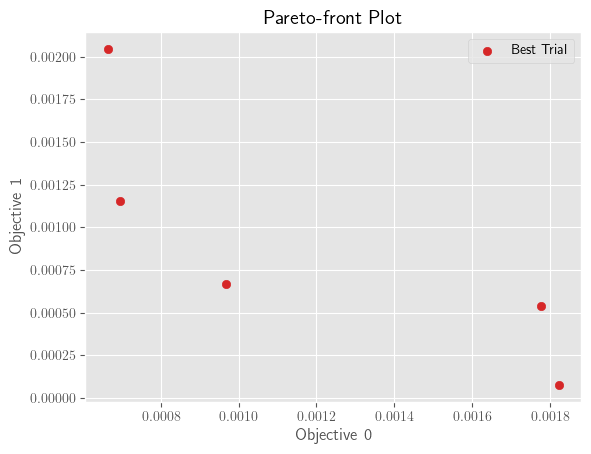

In [55]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [56]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_one_step/trials.joblib']

#### This is the analysis part

In [57]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [58]:
trials_file = save_dir / "trials.joblib"

In [59]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-08-07 16:48:51,849] A new study created in memory with name: no-name-190c60f2-9b4f-4487-ae36-8bb03716a95a


Assuming minimization for all objectives.


In [60]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [61]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

Trial number 49
Trial values: peak_distance 6.704e-04 fwhm 9.667e-04
Trial dw:
{'h_sigma': 0.001034978259457276, 'h_fwhm': 0.0006835937500000583, 'h_centroid': 0.0008265191435300718, 'h_peak': 0.000659179687499999, 'v_sigma': 0.0007800941197414433, 'v_fwhm': 0.0006835937500000583, 'v_centroid': -0.0002731126989430408, 'v_peak': 0.0001220703125, 'integral_intensity': 8337.441238129311, 'peak_intensity': 29.219400589170334, 'gaussian_fit': {}}
Actual fwhm 0.0009667475524035654


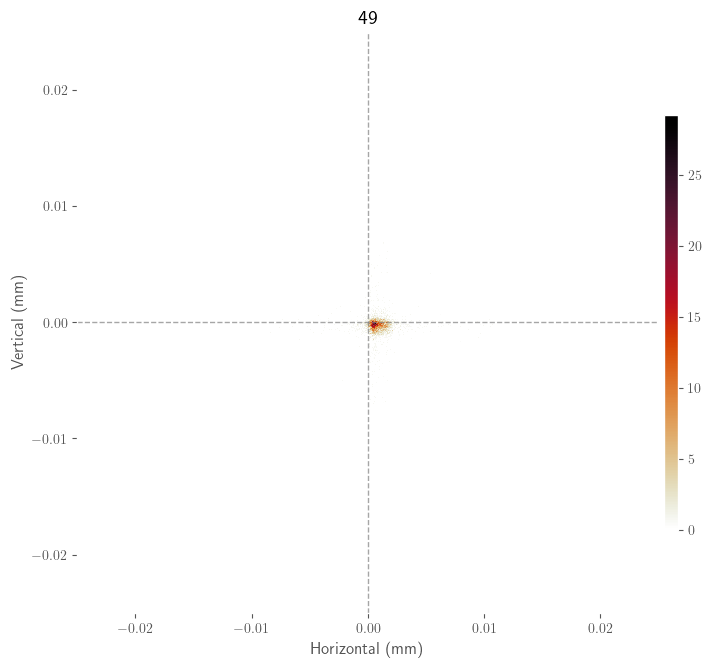

Trial number 76
Trial values: peak_distance 5.404e-04 fwhm 1.777e-03
Trial dw:
{'h_sigma': 0.0011236871667147012, 'h_fwhm': 0.0016601562500001416, 'h_centroid': -0.00017381571895272034, 'h_peak': -0.0005126953125000003, 'v_sigma': 0.0009016963732066232, 'v_fwhm': 0.0006347656250000541, 'v_centroid': -0.00039744238167955295, 'v_peak': 0.00017089843749999896, 'integral_intensity': 8337.311225000152, 'peak_intensity': 17.15456685807271, 'gaussian_fit': {}}
Actual fwhm 0.001777370578437778


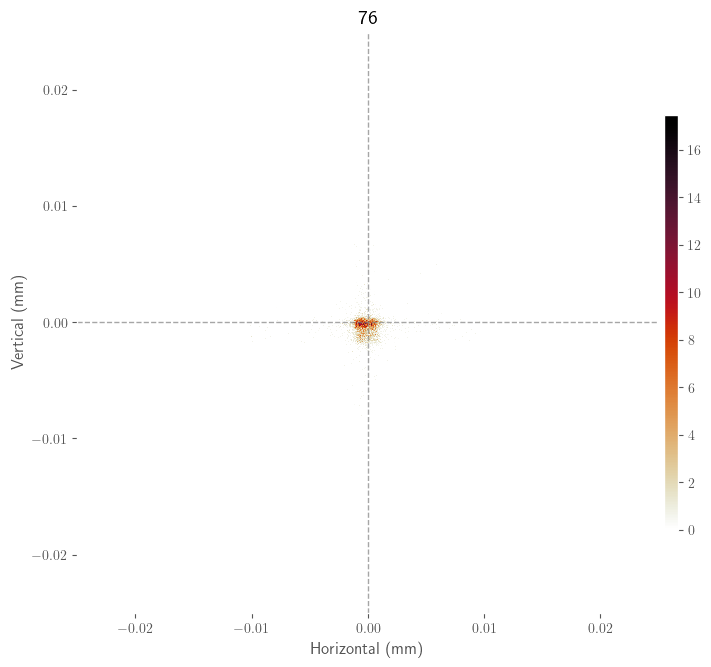

Trial number 79
Trial values: peak_distance 2.045e-03 fwhm 6.641e-04
Trial dw:
{'h_sigma': 0.0008661105634584298, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0018074741796606847, 'h_peak': 0.001879882812499999, 'v_sigma': 0.0009807048569194462, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.00031764608946022063, 'v_peak': -0.000805664062500001, 'integral_intensity': 8336.182782441863, 'peak_intensity': 36.021438605487816, 'gaussian_fit': {}}
Actual fwhm 0.0006641343021844044


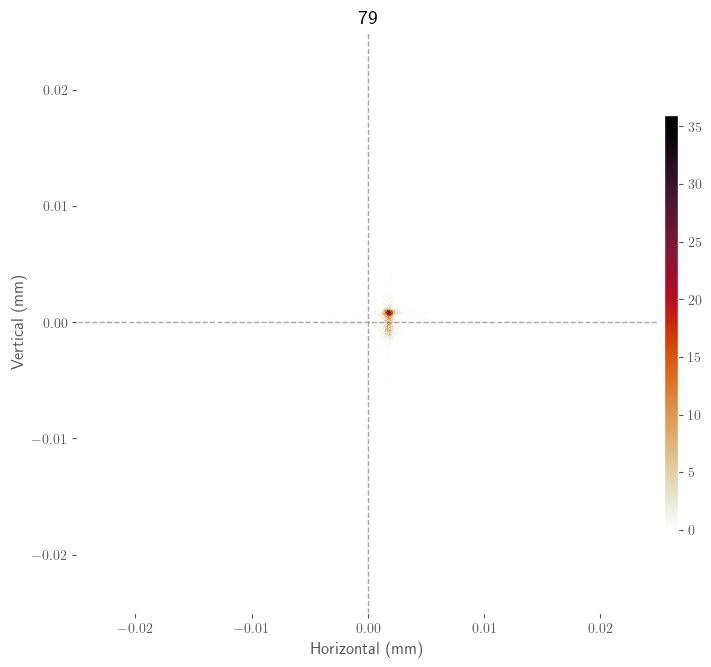

Trial number 94
Trial values: peak_distance 1.154e-03 fwhm 6.940e-04
Trial dw:
{'h_sigma': 0.0009342635522515014, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.00012394832368736839, 'h_peak': 0.0001220703125, 'v_sigma': 0.001171636029323031, 'v_fwhm': 0.00043945312500003747, 'v_centroid': -0.0018937182694599383, 'v_peak': 0.001147460937499999, 'integral_intensity': 8334.975773937935, 'peak_intensity': 35.421964541008435, 'gaussian_fit': {}}
Actual fwhm 0.0006939780470484916


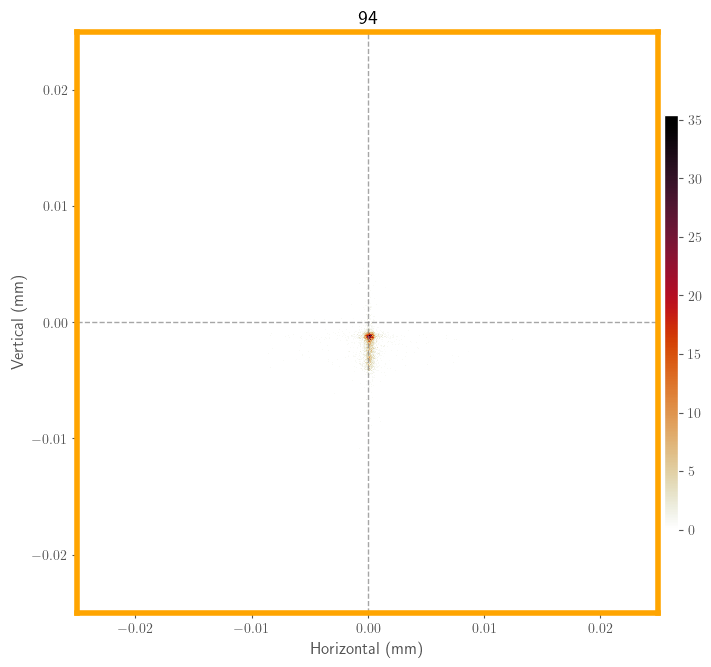

Trial number 99
Trial values: peak_distance 7.720e-05 fwhm 1.823e-03
Trial dw:
{'h_sigma': 0.002118279633609199, 'h_fwhm': 0.0017089843750001457, 'h_centroid': 0.0005440369429563176, 'h_peak': 2.4414062500000347e-05, 'v_sigma': 0.000834066606695005, 'v_fwhm': 0.0006347656250000541, 'v_centroid': -7.559205931910619e-05, 'v_peak': -7.324218750000104e-05, 'integral_intensity': 8344.563451068725, 'peak_intensity': 15.66923399863046, 'gaussian_fit': {}}
Actual fwhm 0.0018230619826753967


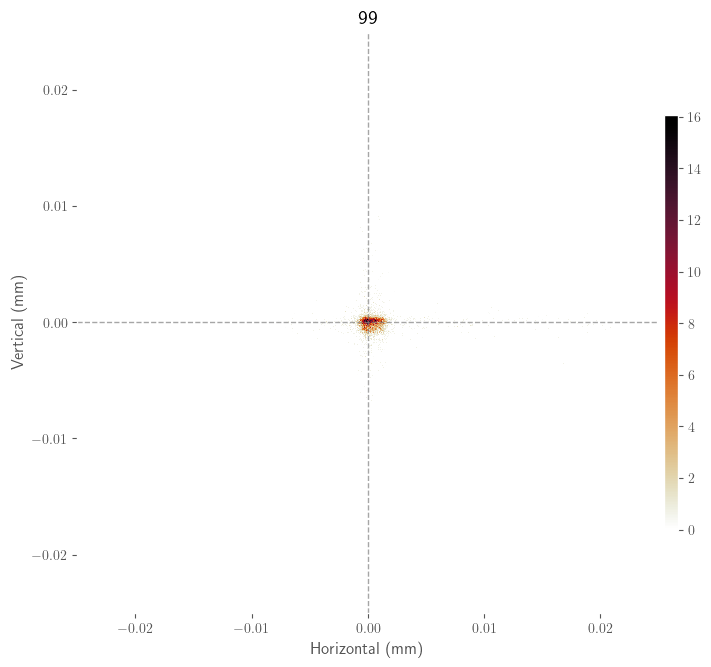

In [62]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()